# Import of libraries.

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
import time
import math
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neural_network import MLPClassifier

# Dataset creation, verification of table's contents.

We'll load dataset using the created function.

In [2]:
def load_dataset(filename, index_col=None):
    dataset = pd.read_csv(f'{filename}', index_col=index_col)
    pd.options.display.max_columns = None
    print(dataset.head())
    print(dataset.tail())
    return dataset

url = 'https://raw.githubusercontent.com/slatkowski/autos_project/main/autos.csv'

df = load_dataset(filename=url)

   index          dateCrawled                            name  seller  \
0      0  2016-03-24 11:52:17                      Golf_3_1.6  privat   
1      1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   
2      2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   
3      3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   
4      4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   

  offerType  price abtest vehicleType  yearOfRegistration    gearbox  powerPS  \
0   Angebot    480   test         NaN                1993    manuell        0   
1   Angebot  18300   test       coupe                2011    manuell      190   
2   Angebot   9800   test         suv                2004  automatik      163   
3   Angebot   1500   test  kleinwagen                2001    manuell       75   
4   Angebot   3600   test  kleinwagen                2008    manuell       69   

   model  kilometer  monthOfRegistration fuelType       brand  \
0   golf 

We have to check when the first and the last advertisement have been published to make data filtering correct.

In [3]:
print(f"Date of the first advertisement: {df['dateCreated'].min()}.")
print(f"Date of the last advertisement: {df['dateCreated'].max()}.")

Date of the first advertisement: 2014-03-10 00:00:00.
Date of the last advertisement: 2016-04-07 00:00:00.


Column "index" contains unique values from 0 to 371528, so we can set it as index column.

In [4]:
print(df.columns)
print(df['index'].value_counts())

df.set_index('index', inplace=True)

Index(['index', 'dateCrawled', 'name', 'seller', 'offerType', 'price',
       'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS',
       'model', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')
0         1
247692    1
247690    1
247689    1
247688    1
         ..
123841    1
123840    1
123839    1
123838    1
371527    1
Name: index, Length: 371528, dtype: int64


Let's proceed to the first information about a DataFrame columns names, non-null values and data types.
Columns "vehicleType", "gearbox", "model", "fuelType" and "notRepairedDamage" contain NaN values.
Also some of the columns which should be the base of prediction, like "vehicleType", "fuelType" or
"gearbox" are object (str) columns.

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

Next, take a look at the descriptive statistics of DataFrame (values round to two places after a comma to better readability).
Unfortunately, there are many outliers - maximum value of column "price" overpasses 2 bilions of euro, we have value (or even values) 
with price = 0, in column "yearOfRegistration" we have cars "registered" in year 1000 and 9999.
Also column "kilometer" may show not enough variance - max value (150000) appears as a median.

In [6]:
df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

price yearOfRegistration    powerPS  kilometer  \
count      371528.00          371528.00  371528.00  371528.00   
mean        17295.14            2004.58     115.55  125618.69   
std       3587953.74              92.87     192.14   40112.34   
min             0.00            1000.00       0.00    5000.00   
25%          1150.00            1999.00      70.00  125000.00   
50%          2950.00            2003.00     105.00  150000.00   
75%          7200.00            2008.00     150.00  150000.00   
max    2147483647.00            9999.00   20000.00  150000.00   

      monthOfRegistration nrOfPictures postalCode  
count           371528.00    371528.00  371528.00  
mean                 5.73         0.00   50820.67  
std                  3.71         0.00   25799.08  
min                  0.00         0.00    1067.00  
25%                  3.00         0.00   30459.00  
50%                  6.00         0.00   49610.00  
75%                  9.00         0.00   71546.00  
max                 12.00         0.00   99998.00

Next action will be counting all values from object cols - function to use in this purpose is defined below.

In [7]:
def DFCounter(df):
    #1. Iteration over columns
    for col in df.columns:
        #2. Printing of every column values and their numbers
        print(df[col].value_counts())
        #3. Cross line to separate and make printing clear
        print('_______________________')
        
str_cols = df.select_dtypes(include='object')
DFCounter(str_cols)

2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-22 10:42:10    5
2016-04-01 16:52:05    5
                      ..
2016-03-20 15:56:21    1
2016-03-14 03:22:32    1
2016-03-14 22:52:34    1
2016-03-31 23:53:26    1
2016-03-07 19:39:19    1
Name: dateCrawled, Length: 280500, dtype: int64
_______________________
Ford_Fiesta                                              657
BMW_318i                                                 627
Opel_Corsa                                               622
Volkswagen_Golf_1.4                                      603
BMW_316i                                                 523
                                                        ... 
Audi_A4_Avant_Klima_Gruene_Plakette_TÜV_&AU_NEU_XENON      1
Renault_clio_in_gold_450VB_!!                              1
Fiat_Doblo_1.6_Multijet                                    1
Renault_Laguna_1                                           1
BMW_M135i_vollausgestattet_NP_52.720____Eur

Displaying columns with NaN-s; columns "vehicleType", "gearbox", "model", "fuelType" and "notRepairedDamage" contain missing values.

<Figure size 1000x600 with 0 Axes>

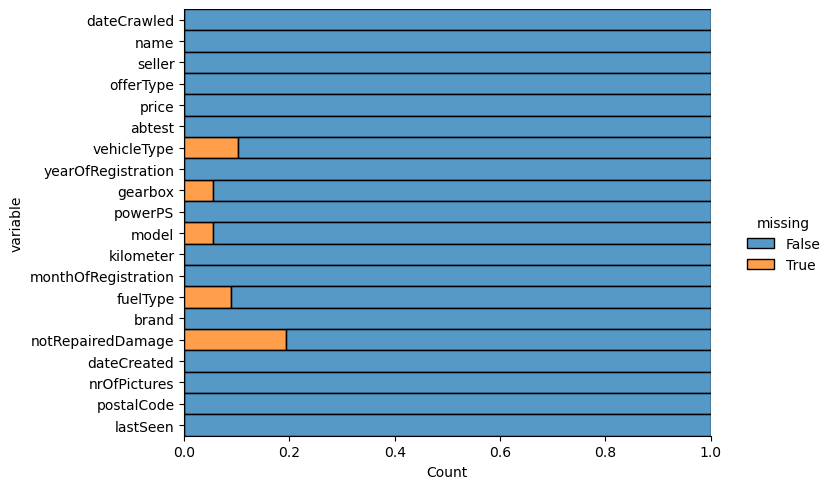

In [8]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.5
)

plt.show()

# Feature engineering.

The goal of this project is to create an efficient model dividing cars sale adverts into two groups - premium cars and non-premium cars with date of first registration in XXI Century, based only on features mentioned in advert. Binary classifier like that could be useful for market exploration and also for creating algorithm assigning adverts to one of these groups, and as consequence, helping customers in navigation on the website.

We can start with creating labels. Some of the premium brands are hidden behind the term "sonstige_autos". We have to "decode" that records.

In [9]:
lst = ['ferrari', 'maserati', 'lexus', 'aston', 'bugatti', 'mclaren',
       'acura', 'royce', 'bentley', 'lamborghini', 'tesla', 'infiniti']

df['name'] = df['name'].str.lower()

for i in lst:
  for name in df['name'].values:
    if i in name:
      df.loc[df['name'].str.contains(i), 'brand'] = 'Premium brand'

Now we have to group brands into two categories (premium and other) instead of original car producers.

In [10]:
lst = [(['volkswagen', 'opel', 'ford', 'renault', 
         'peugeot', 'fiat', 'seat', 'mazda', 'skoda', 
         'citroen', 'nissan', 'toyota', 'hyundai',
        'mitsubishi', 'honda', 'kia', 'suzuki',
        'chevrolet', 'chrysler', 'dacia', 'daihatsu', 
        'subaru', 'trabant', 'daewoo', 'rover', 'smart', 
         'lada', 'lancia', 'saab', 'sonstige_autos'], 'Other brand'),
       (['bmw', 'mercedes_benz', 'audi', 'mini', 'volvo', 
         'alfa_romeo', 'porsche', 'land_rover', 'jaguar', 
         'jeep'], 'Premium brand')]

repl_dict = {}
for x,y in lst:
    repl_dict.update(dict.fromkeys(x,y))

df['brand'] = df['brand'].replace(repl_dict)

print(df['brand'].value_counts())

Other brand      249188
Premium brand    122340
Name: brand, dtype: int64


The next operation is getting rid of outliers. We're taking into consideration only cars registered in the XXI century, 
with price in price bracket 200-55000 euros and engine power (in HP/PS) bracket 39 (HP of Fiat Seicento) to 500 
(some of the brands have more powerful models, but they are not common and can be considered as outliers).

In [11]:
df = df[(df['yearOfRegistration'] >= 2001) & (df['yearOfRegistration'] <= 2016)]
df = df[(df['price'] >= 100) & (df['price'] <= 100000)]
df = df[(df['powerPS'] >= 39) & (df['powerPS'] <= 750)]

Replacing hidden missing values as NaN-s (in German: "andere" - "other").

In [12]:
df.replace('andere', np.nan, inplace=True)

We can see that operations above made the dataset about two times smaller.
Number of samples decreased about two times.

In [13]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207870 entries, 1 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          207870 non-null  object
 1   name                 207870 non-null  object
 2   seller               207870 non-null  object
 3   offerType            207870 non-null  object
 4   price                207870 non-null  int64 
 5   abtest               207870 non-null  object
 6   vehicleType          198519 non-null  object
 7   yearOfRegistration   207870 non-null  int64 
 8   gearbox              204793 non-null  object
 9   powerPS              207870 non-null  int64 
 10  model                190336 non-null  object
 11  kilometer            207870 non-null  int64 
 12  monthOfRegistration  207870 non-null  int64 
 13  fuelType             199621 non-null  object
 14  brand                207870 non-null  object
 15  notRepairedDamage    185437 non-nu

Our dataset suffers from deficiency of continuous numeric features. By dividing column 'price' per column 'powerPS' we'll get column 'priceOf1PS' which can bring us some useful informations. It's intuitive to assume that we'll have to pay more for 1 HP/PS of premium car engine's power.

In [14]:
df['priceOf1PS'] = df['price']/df['powerPS']

Next look at the values numbers should show us which columns we can drop without information loss. 

In [15]:
str_cols = df.select_dtypes(include='object')
DFCounter(str_cols)

2016-03-05 14:25:23    5
2016-03-27 15:50:58    4
2016-03-12 13:38:19    4
2016-03-25 17:46:14    4
2016-03-13 15:25:23    4
                      ..
2016-03-18 17:06:18    1
2016-03-23 15:37:06    1
2016-03-17 10:55:36    1
2016-03-20 23:41:40    1
2016-03-07 19:39:19    1
Name: dateCrawled, Length: 177712, dtype: int64
_______________________
volkswagen_polo_1.2                                          397
bmw_116i                                                     393
opel_corsa_1.2_16v                                           352
opel_corsa_1.0_12v                                           310
ford_fiesta                                                  286
                                                            ... 
mercedes_benz_mercedes_b_170_sportpaket                        1
bmw_316_benzin_klimaautomatik_2003_fuer_1550_euro              1
mercedes_benz_c_320_cdi_avantgarde_ahk_xenon_aux_navi_...      1
chevrolet_matiz_zu_verkaufen                                   1
bmw

We should remove the columns which don't bring useful informations (referring to dates, 'name'), not referring to cars' properties ('abtest' - it brings us information about the version of the website), undifferentiated ('nrOfPictures', 'seller' and 'offerType') and being a data leakage ('model').

In [16]:
df.drop(columns=['dateCrawled', 'name', 'monthOfRegistration', 'seller',
                 'model', 'dateCreated', 'lastSeen', 'nrOfPictures',
                'offerType', 'abtest'], inplace=True)

print(df.columns)

Index(['price', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS',
       'kilometer', 'fuelType', 'brand', 'notRepairedDamage', 'postalCode',
       'priceOf1PS'],
      dtype='object')


Next look at the values - filtering went correctly, but we still have missing values in four columns.

In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207870 entries, 1 to 371527
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               207870 non-null  int64  
 1   vehicleType         198519 non-null  object 
 2   yearOfRegistration  207870 non-null  int64  
 3   gearbox             204793 non-null  object 
 4   powerPS             207870 non-null  int64  
 5   kilometer           207870 non-null  int64  
 6   fuelType            199621 non-null  object 
 7   brand               207870 non-null  object 
 8   notRepairedDamage   185437 non-null  object 
 9   postalCode          207870 non-null  int64  
 10  priceOf1PS          207870 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 19.0+ MB
None


In [18]:
df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

price yearOfRegistration    powerPS  kilometer postalCode  \
count  207870.00          207870.00  207870.00  207870.00  207870.00   
mean     8115.07            2006.73     135.44  118968.56   52284.49   
std      8220.23               4.01      64.02   41915.00   25614.35   
min       100.00            2001.00      39.00    5000.00    1067.00   
25%      2800.00            2003.00      90.00   90000.00   32052.00   
50%      5555.00            2006.00     125.00  150000.00   51503.00   
75%     10500.00            2010.00     163.00  150000.00   73033.00   
max     99999.00            2016.00     750.00  150000.00   99998.00   

      priceOf1PS  
count  207870.00  
mean       56.57  
std        41.66  
min         0.24  
25%        26.47  
50%        45.83  
75%        75.88  
max      1408.44

<Figure size 1000x600 with 0 Axes>

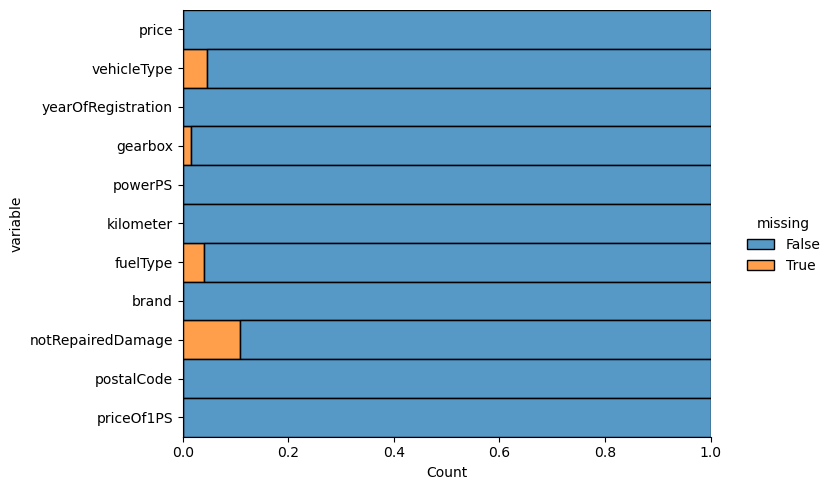

In [19]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.5
)

plt.show()

To replace NaNs with values we should define a function which replaces them with values according to probability of their appearance in the column where NaNs appear.

In [20]:
def NANFiller(df):
    #1. calling function columnFiller to modify column
    def columnFiller(series):
        #2. assigning number of NaN-s in column to a variable
        nan_c = len(series[series.isna()])
        #3. taking values from column with no NaN and assigning them to a temporary Series
        nnan_c = series[series.notna()]
        #4. counting not-NaN values from temporary Series
        count_nn = Counter(nnan_c)    
        #5. choosing random values according to probabilities of their apperance
        new_val = random.choices(list(count_nn.keys()), weights = list(count_nn.values()), k=nan_c)
        series[series.isna()] = new_val
        #6. returning column with new values
        return series
    #7. repeating operation above for the whole DataFrame
    for col in df.columns:
        df[col]=columnFiller(df[col])
        
NANFiller(df)

Good idea is also transformation columns 'postalCode' and 'kilometer' into discrete feature. Basing on an postal division of Germany (into 10 leitzones from 0 to 9: https://en.wikipedia.org/wiki/Postal_codes_in_Germany) we can acquire knowledge about geographical origin of advert and which market is the primal for each category. On the other hand, values from 'kilometer' (mileage) column doesn't have enough variance, but we want to have any profit from using it, so transformation could be necessary.

In [21]:
bins = [0, 9999, 19999, 29999, 39999,
        49999, 59999, 69999, 79999, 89999, 99999]

df['postalCode'] = pd.cut(df['postalCode'], bins=bins,
       labels=['Leitzone 0', 'Leitzone 1', 'Leitzone 2', 'Leitzone 3',
              'Leitzone 4', 'Leitzone 5', 'Leitzone 6', 'Leitzone 7',
              'Leitzone 8', 'Leitzone 9'])

bins = [0, 29999, 59999, 99999, 149999, 150001]

df['kilometer'] = pd.cut(df['kilometer'], bins=bins,
                         labels=['0-29999', '30000-59999', '60000-99999', '100000-149999', 'Over 150000 km'])

# Exploratory Data Analysis.

We've got demanded brackets now. Changes caused about two-fold decrease of samples number.

In [22]:
df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

price yearOfRegistration    powerPS priceOf1PS
count  207870.00          207870.00  207870.00  207870.00
mean     8115.07            2006.73     135.44      56.57
std      8220.23               4.01      64.02      41.66
min       100.00            2001.00      39.00       0.24
25%      2800.00            2003.00      90.00      26.47
50%      5555.00            2006.00     125.00      45.83
75%     10500.00            2010.00     163.00      75.88
max     99999.00            2016.00     750.00    1408.44

In [23]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207870 entries, 1 to 371527
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               207870 non-null  float64 
 1   vehicleType         207870 non-null  object  
 2   yearOfRegistration  207870 non-null  float64 
 3   gearbox             207870 non-null  object  
 4   powerPS             207870 non-null  float64 
 5   kilometer           207870 non-null  category
 6   fuelType            207870 non-null  object  
 7   brand               207870 non-null  object  
 8   notRepairedDamage   207870 non-null  object  
 9   postalCode          207870 non-null  category
 10  priceOf1PS          207870 non-null  float64 
dtypes: category(2), float64(4), object(5)
memory usage: 16.3+ MB
None


In [24]:
str_cols = df.select_dtypes(include='object')
DFCounter(str_cols)

limousine     55502
kombi         46611
kleinwagen    45860
bus           22956
cabrio        14718
suv           11964
coupe         10259
Name: vehicleType, dtype: int64
_______________________
manuell      154378
automatik     53492
Name: gearbox, dtype: int64
_______________________
benzin     114760
diesel      89430
lpg          2937
cng           465
hybrid        239
elektro        39
Name: fuelType, dtype: int64
_______________________
Other brand      134879
Premium brand     72991
Name: brand, dtype: int64
_______________________
nein    191512
ja       16358
Name: notRepairedDamage, dtype: int64
_______________________


<Figure size 640x480 with 0 Axes>

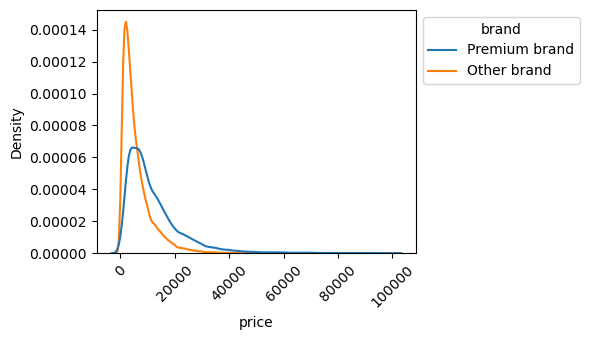

<Figure size 640x480 with 0 Axes>

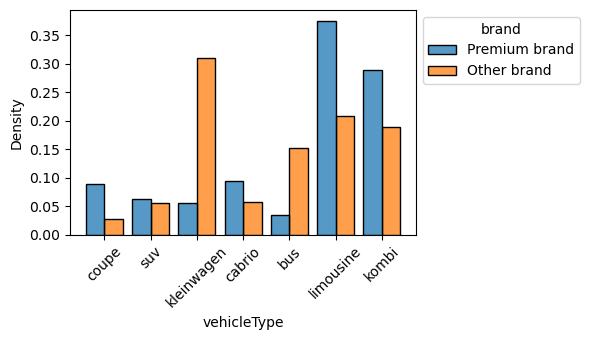

<Figure size 640x480 with 0 Axes>

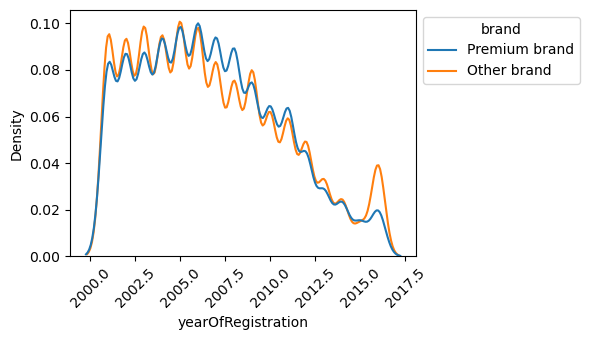

<Figure size 640x480 with 0 Axes>

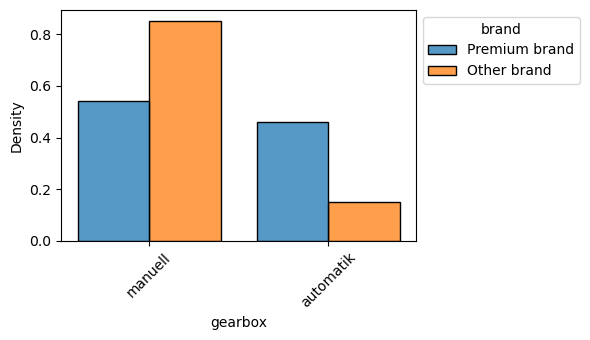

<Figure size 640x480 with 0 Axes>

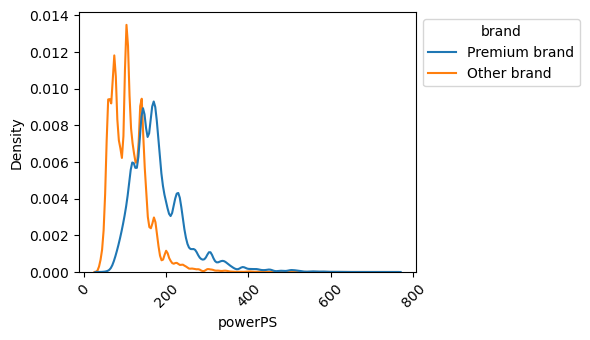

<Figure size 640x480 with 0 Axes>

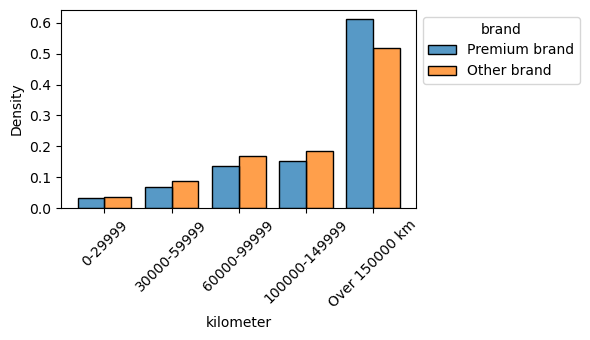

<Figure size 640x480 with 0 Axes>

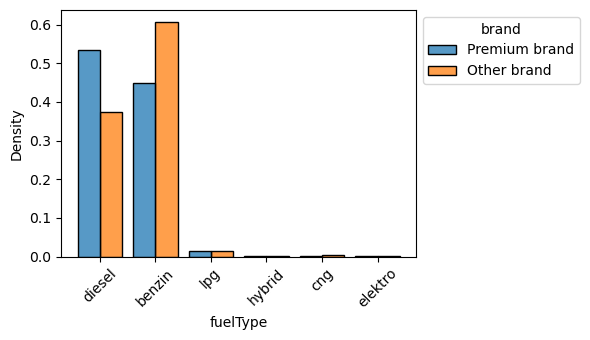

<Figure size 640x480 with 0 Axes>

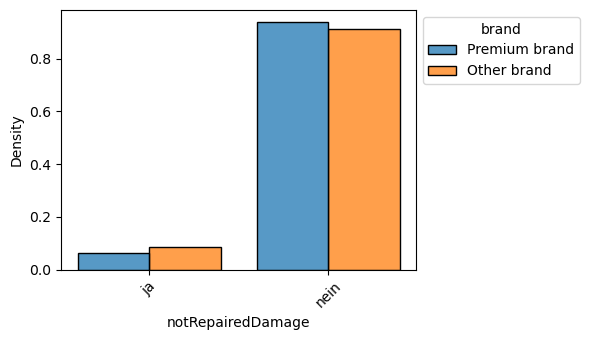

<Figure size 640x480 with 0 Axes>

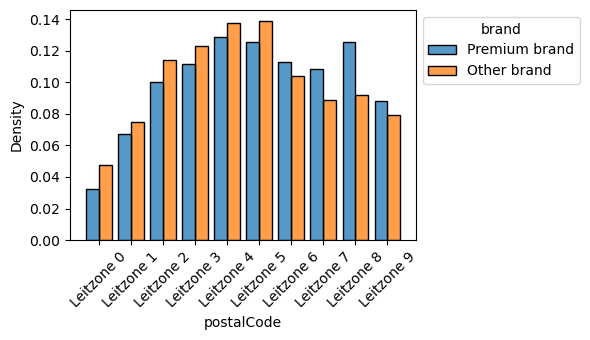

<Figure size 640x480 with 0 Axes>

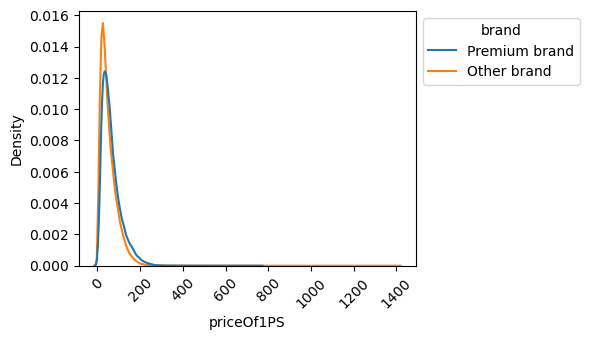

In [25]:
_ = df.drop(columns=['brand'])
cols_wo_brands = list(_.columns)

rotation = 45
legend = (1, 1)
figsize = (6, 3.5)

for i, col in enumerate(df[cols_wo_brands]):
    plt.figure(i)
    fig, ax = plt.subplots(figsize=figsize)
    if df[col].dtype == 'object':
        ax = sns.histplot(x=col, data=df, 
                          hue='brand', multiple="dodge", 
                          stat = 'density', shrink = 0.8, common_norm=False)
        sns.move_legend(ax, "upper left", bbox_to_anchor=legend)
        plt.xticks(rotation=rotation)
    elif df[col].dtype == 'category':
        ax = sns.histplot(x=col, data=df, 
                          hue='brand', multiple="dodge",
                          stat = 'density', shrink = 0.8, common_norm=False)
        sns.move_legend(ax, "upper left", bbox_to_anchor=legend)
        plt.xticks(rotation=rotation)
    else:
        ax = sns.kdeplot(x=col, data=df,
                         hue='brand', common_norm=False)
        sns.move_legend(ax, "upper left", bbox_to_anchor=legend)
        plt.xticks(rotation=rotation)
        
    plt.tight_layout()
    plt.show()

On normalized plots we can see that:
1. Non-premium cars have huge advantage in hatchback (kleinwagen) and bus models. Premium models are relatively more likely to be limousines, cabrios, coupes and combis. SUVs frequency are almost the same with a small advantage of premium brands.
2. Advantage of manual gearboxes is merely visible in premium brands group and much bigger in non-premium category.
3. Distrubutions of first registration dates are quite similar. The most models from each group come from years 2001-2009. Bigger amount of relatively new models (from years 2014-2016) are non-premium.
4. In column 'powerPS' we can see that there's not much samples of cars with power over 550 HP. However, we can see that distributions have similar shape, but different values - for non-premium peak is about 100-120 HP, for premium - 180-200 HP.
5. Relatively more premium cars have mileages over 150000 km.
6. More premium cars have diesel engines than petrol, non-premium - opposite. Other fuel types have marginal meaning.
7. Premium cars adverts are relatively more frequent in Southern Germany (Leitzones 6-9). However, there's no region in which we have big advantage of any of the groups.
8. Also column showing if car is damaged at the time when advert is published doesn't show much variance.
9. Columns 'price' and 'priceOf1PS' aren't readable enough because of outliers.

As we can see, not everyone of the outliers have been removed. There are very little amount of samples with price over 60000 euros, engine power more than 550 HP, duration of advert publication more than 720 hours (30 days, one full month) and price of 1 HP more than 300 euros. We can narrow down the brackets of these columns to plot them once again. Also "notRepairedDamage" column's variance is doubtful.

In [26]:
df = df[df['price'] <= 60000]
df = df[df['powerPS'] <= 550]
df = df[df['priceOf1PS'] <= 300]
df.drop(columns='notRepairedDamage', inplace=True)

<Figure size 640x480 with 0 Axes>

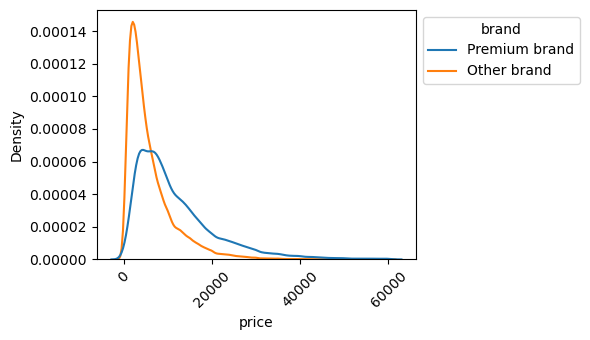

<Figure size 640x480 with 0 Axes>

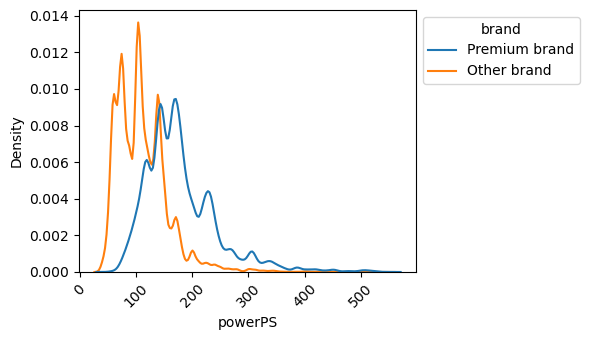

<Figure size 640x480 with 0 Axes>

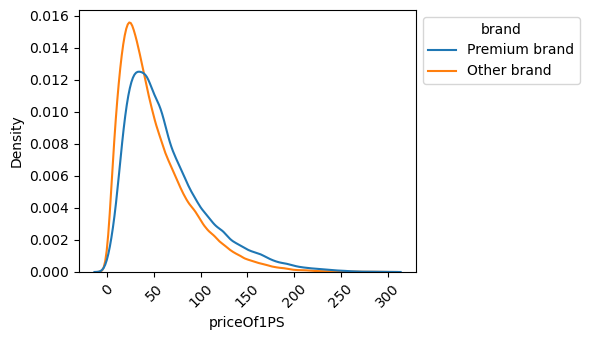

In [27]:
continuous_cols = ['price',
                   'powerPS',
                   'priceOf1PS']

for i, col in enumerate(df[continuous_cols]):
    plt.figure()
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.kdeplot(x=col, data=df,
                         hue='brand', common_norm=False)
    sns.move_legend(ax, "upper left", bbox_to_anchor=legend)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

When it comes to the corrected plots:
1. Column 'powerPS' confirms our conclusion above.
2. Price distribution of premium brands is much more flattened. Non-premium brands' distribution reach their peak earlier and falls rapidly. From about 10000 euros premium cars are two times more numerous. That situation is quite similar in column 'priceOf1PS', but differences between both distibutions are closer.

# Preprocessing of data.

To transform columns with strings into categorical, we'll define function based on LabelEncoder.

In [28]:
le = LabelEncoder()
encode_list = ['gearbox', 'vehicleType', 'fuelType', 
               'kilometer', 'postalCode']

def EncodingDesc(series, le):
    #1. transformation of pd.Series/pd.DataFrame.column
    transformed = le.fit_transform(series)
    #2. displaying the name of Series/column
    print(series.name)
    #3. displaying names of unique classes
    print(le.classes_)
    #4. displaying classes values after encoding
    print(np.unique(transformed))
    #5. returning transformed Series/column
    return transformed

for i in encode_list:
    df[i] = EncodingDesc(df[i], le)
    print('______________________')

gearbox
['automatik' 'manuell']
[0 1]
______________________
vehicleType
['bus' 'cabrio' 'coupe' 'kleinwagen' 'kombi' 'limousine' 'suv']
[0 1 2 3 4 5 6]
______________________
fuelType
['benzin' 'cng' 'diesel' 'elektro' 'hybrid' 'lpg']
[0 1 2 3 4 5]
______________________
kilometer
['0-29999' '100000-149999' '30000-59999' '60000-99999' 'Over 150000 km']
[0 1 2 3 4]
______________________
postalCode
['Leitzone 0' 'Leitzone 1' 'Leitzone 2' 'Leitzone 3' 'Leitzone 4'
 'Leitzone 5' 'Leitzone 6' 'Leitzone 7' 'Leitzone 8' 'Leitzone 9']
[0 1 2 3 4 5 6 7 8 9]
______________________


## Profile Report.

Analytic report shows that dependent variable has quite much correlation with variable "power". The strongest correlation (0.884 in Pearson scale) takes place between total car price and price of 1 HP.
Also there's no variable with distribution similar to normal. We can also observe that report sees a visible amount of duplicate rows, but it's probably due to the fact that some of the adverts refer to the similar car models.

In [29]:
report = ProfileReport(df, infer_dtypes=False)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Using a pivot table we can take a look at descriptive stats of each brand. Basing on mean, standard deviation and our previous observations we can see that the variables providing the greatest variance are: gearbox, engine power, total price and price of 1 HP.

In [30]:
pivot = pd.pivot_table(df, index='brand', values = ['price', 'vehicleType', 'yearOfRegistration',
                                                    'gearbox', 'powerPS', 'fuelType',
                                                    'postalCode', 'kilometer', 'priceOf1PS'], 
                       aggfunc= [np.mean, np.median, np.std, min, max])
display(pivot)

mean                                             \
               fuelType   gearbox kilometer postalCode     powerPS   
brand                                                                
Other brand    0.826505  0.852214  2.947951   4.610903  110.986147   
Premium brand  1.149113  0.542792  3.146657   4.977213  178.661279   

                                                                       \
                      price priceOf1PS vehicleType yearOfRegistration   
brand                                                                   
Other brand     5952.991119  51.696954    3.175595        2006.746669   
Premium brand  11659.803933  64.372858    3.846401        2006.661983   

                median                                               \
              fuelType gearbox kilometer postalCode powerPS   price   
brand                                                                 
Other brand          0       1         4          5   105.0  4199.0   
Premium brand        2       1         4          5   170.0  8999.0   

                                                              std            \
              priceOf1PS vehicleType yearOfRegistration  fuelType   gearbox   
brand                                                                         
Other brand    41.428571           3             2006.0  1.090953  0.354889   
Premium brand  53.617571           4             2006.0  1.094148  0.498169   

                                                                       \
              kilometer postalCode    powerPS        price priceOf1PS   
brand                                                                   
Other brand    1.297018   2.538372  45.410664  5589.850393  38.041714   
Premium brand  1.248222   2.537943  64.259565  9189.839703  43.334419   

                                                  min                    \
              vehicleType yearOfRegistration fuelType gearbox kilometer   
brand                                                                     
Other brand      1.762716           4.086893        0       0         0   
Premium brand    1.551846           3.829449        0       0         0   

                                                                \
              postalCode powerPS  price priceOf1PS vehicleType   
brand                                                            
Other brand            0    39.0  100.0   0.558659           0   
Premium brand          0    50.0  100.0   0.240000           0   

                                      max                               \
              yearOfRegistration fuelType gearbox kilometer postalCode   
brand                                                                    
Other brand               2001.0        5       1         4          9   
Premium brand             2001.0        5       1         4          9   

                                                                           
              powerPS    price  priceOf1PS vehicleType yearOfRegistration  
brand                                                                      
Other brand     547.0  60000.0  299.285714           6             2016.0  
Premium brand   550.0  60000.0  299.994118           6             2016.0

## Sets division.

Now we're ready to divide dataset into features (X) and labels (y).

In [31]:
X = df.drop(columns='brand')
y = df['brand']

Also we have to encode our labels.

In [32]:
y = le.fit_transform(y)
print(y)
print(type(y))
print(le.classes_)

[1 1 0 ... 0 0 1]
<class 'numpy.ndarray'>
['Other brand' 'Premium brand']


Sets need to be split. We'll use train_test_split method and create training, validation and test sets.

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_val,
                                                    y_val,
                                                    test_size = 0.5,
                                                    random_state = 42,
                                                    stratify=y_val)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (155423, 9)
X_val shape: (25904, 9)
X_test shape: (25904, 9)
y_train shape: (155423,)
y_val shape: (25904,)
y_test shape: (25904,)


## Data normalization.

StandardScaler will help us to normalize features.

In [34]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

Checking the imbalance between classes is important to set class weights in estimator.

In [35]:
counter = Counter(y)
imbalance = counter[0]/counter[1]
print(f'Imbalance of classes equals: {imbalance}.')

Imbalance of classes equals: 1.86013387619902.


# Modelling.

The problem we're trying to solve is non-linear. There is not a straight-line or direct relationship between an independent variables and a dependent variable. That's why we should use compound algorithms to make proper classification. We'll test four algorithms: XGBClassifier, Balanced Random Forest Classifier, K-Neighbors Classifier and Complement Naive Bayes.

##  XGBClassifier.

The first algorithm we've chosen to solve classification problem is XGBClassifier. It's efficient ensemble classifier, keeping what's the best from random forest idea and adding gradient boosting, which advantage is improving results of learning after each estimator. This problem isn't linear and therefore usage of more complicated algorithm could bring more profits.

We'll adjust only the params with the biggest influence on model's metrics:
1. Set steady:
- N_estimators - number of trees/learning epochs: 300 (to let the classifier learn as long as it's necessary,
- Objective - 'binary:logistic': logistic regression for binary classification, output probability,
- Eval_metric - evaluation metrics for validation data: 'error' (binary classification error rate = wrong cases/all cases),
- Scale_pos_weight - balance control rate for imbalanced classes in binary classification (negative classes/positive classes).

2. To adjust by RandomizedSearchCV:
- Max_depth - depth of the tree estimator; we'll start from the estimators with default (6) and default-1 (5) max_depth,
- Learning_rate - how much the feature weights will shrink after each boosting step,
- Reg_lambda - L2 regularization rate,
- Reg_alpha - L1 regularization rate.

Moreover we'll set early_stopping_rounds param equal to 15; after 15 boosting step with no progress learning crossvalidation will stop. Crossvalidation number for each combination of params equals 5. 

In [37]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=300, 
    objective= 'binary:logistic', 
    eval_metric='error',
    scale_pos_weight = imbalance
)

params = {
    'max_depth': [5, 6],
    'learning_rate': [0.2, 0.3],
    'reg_lambda': [0.8, 1],
    'reg_alpha': [0, 0.2]
}

fit_params = {
    'early_stopping_rounds': 15, 
    'eval_set' : [[X_val_sc, y_val]],
    'verbose': None
}

cv = 5

rs_xgb = RandomizedSearchCV(
    xgb_clf, 
    param_distributions=params,
    cv=cv,
    verbose=3
)
    
start = time.time()
rs_xgb.fit(X_train_sc, y_train, **fit_params)
rs_xgb_train_pred = rs_xgb.predict(X_train_sc)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins} mins and {seconds} s.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.2, max_depth=6, reg_alpha=0, reg_lambda=1;, score=0.894 total time=  23.2s
[CV 2/5] END learning_rate=0.2, max_depth=6, reg_alpha=0, reg_lambda=1;, score=0.888 total time=  11.1s
[CV 3/5] END learning_rate=0.2, max_depth=6, reg_alpha=0, reg_lambda=1;, score=0.898 total time=  24.1s
[CV 4/5] END learning_rate=0.2, max_depth=6, reg_alpha=0, reg_lambda=1;, score=0.897 total time=  25.1s
[CV 5/5] END learning_rate=0.2, max_depth=6, reg_alpha=0, reg_lambda=1;, score=0.892 total time=  21.7s
[CV 1/5] END learning_rate=0.2, max_depth=6, reg_alpha=0.2, reg_lambda=1;, score=0.890 total time=  14.7s
[CV 2/5] END learning_rate=0.2, max_depth=6, reg_alpha=0.2, reg_lambda=1;, score=0.898 total time=  24.3s
[CV 3/5] END learning_rate=0.2, max_depth=6, reg_alpha=0.2, reg_lambda=1;, score=0.898 total time=  22.7s
[CV 4/5] END learning_rate=0.2, max_depth=6, reg_alpha=0.2, reg_lambda=1;, score=0.896 total time=  2

Scores in positive class - premium - are decent. About 91% of its cases have been detected (as it's indicated by recall in validation and test sets). However, we have to check if the model's metrics rise if the estimators depth value (probably the key parameter) will be bigger.

In [38]:
print(f"XGBClassifier best params adjusted by RandomizedSearchCV: {rs_xgb.best_params_}.")
print(f"Best score of this setting: {rs_xgb.best_score_}.")

rs_xgb_val_pred = rs_xgb.predict(X_val_sc)
rs_xgb_test_pred = rs_xgb.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, rs_xgb_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, rs_xgb_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rs_xgb_test_pred)}')

XGBClassifier best params adjusted by RandomizedSearchCV: {'reg_lambda': 0.8, 'reg_alpha': 0, 'max_depth': 6, 'learning_rate': 0.3}.
Best score of this setting: 0.8974154277087202.
Training metrics:

              precision    recall  f1-score   support

           0       0.96      0.91      0.94    101082
           1       0.85      0.93      0.89     54341

    accuracy                           0.92    155423
   macro avg       0.91      0.92      0.91    155423
weighted avg       0.92      0.92      0.92    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     16847
           1       0.83      0.91      0.87      9057

    accuracy                           0.90     25904
   macro avg       0.89      0.90      0.89     25904
weighted avg       0.91      0.90      0.90     25904

_____________________________________________________

Test metrics:



Confusion matrixes only confirm these conclusions.

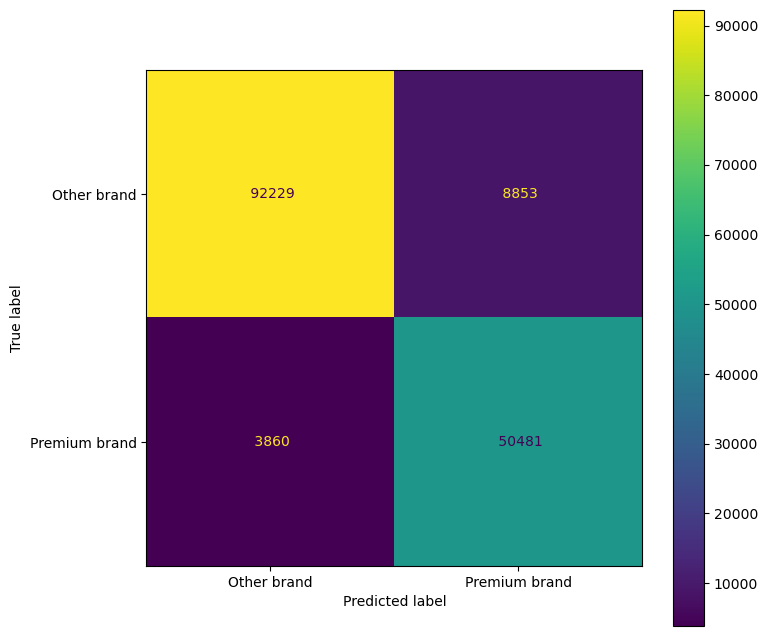

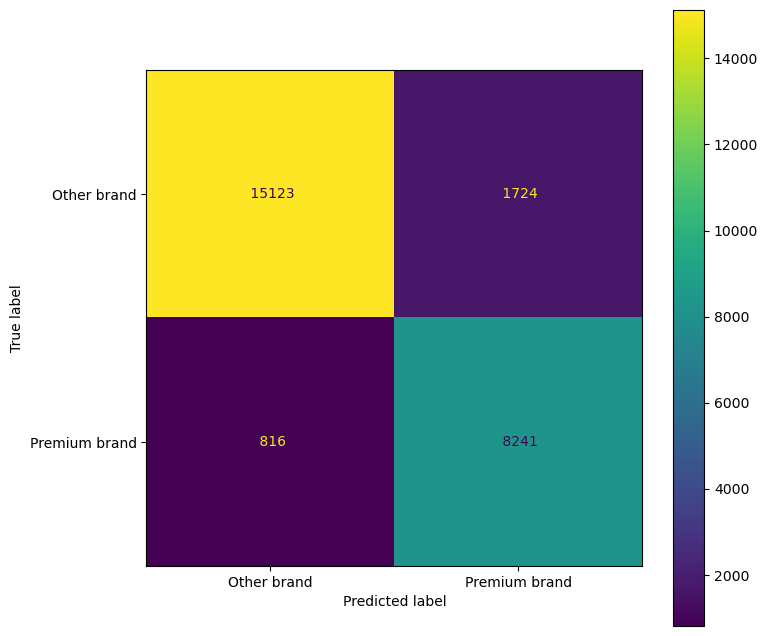

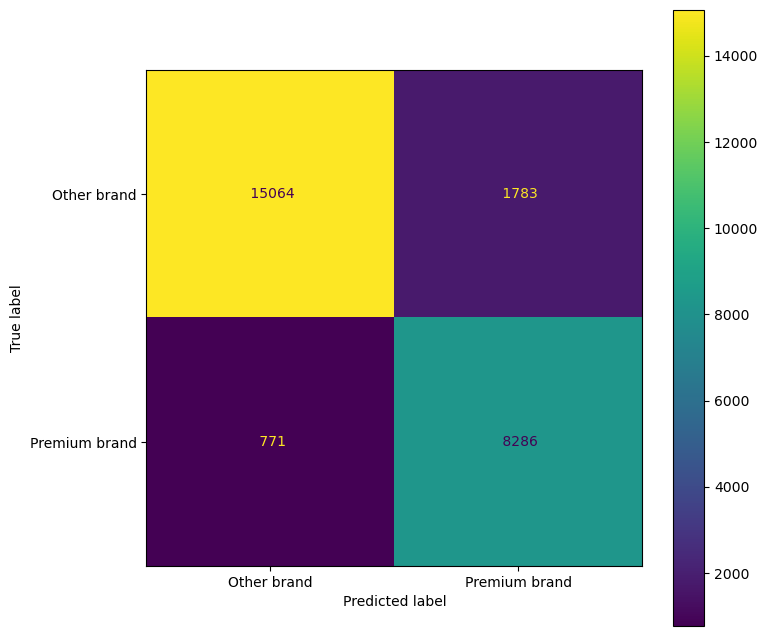

In [39]:
brands = le.classes_

def conf_matrix_show(estimator, X, y, classes):
    #1. Drawing the plot, setting the plot's default size.
    fig, ax = plt.subplots(figsize=(8,8))
    #2. Creating the instance of confusion matrix from estimator and set, and displaying classes to predict.
    cmd = ConfusionMatrixDisplay.from_estimator(estimator, X, y, display_labels=classes, ax=ax, values_format=' ')
    #3. Disabling grid - it makes confusion matrix much more readable. 
    ax.grid(False)

    
conf_matrix_show(rs_xgb, X_train_sc, y_train, brands)
conf_matrix_show(rs_xgb, X_val_sc, y_val, brands)
conf_matrix_show(rs_xgb, X_test_sc, y_test, brands)

The main problem with fitting could be in estimators' depth - the deeper they are, the bigger an adjusting to training set is, but also it can widen the model's decision area. Next model with use of RandomizedSearchCV will be fitted with bigger values of max_depth. We'll also check more values of other params.

In [40]:
params = {
    'max_depth': [7, 8],
    'learning_rate': [0.1, 0.2, 0.3],
    'reg_lambda': [0.6, 0.8, 1],
    'reg_alpha': [0, 0.1, 0.2]
}

fit_params = {
    'early_stopping_rounds': 15, 
    'eval_set' : [[X_val_sc, y_val]],
    'verbose': None
}

rs_xgb2 = RandomizedSearchCV(
    xgb_clf, #we'll call the previous instance
    param_distributions=params,
    cv=cv, #cv = 5, variable declared above
    verbose=3
)
    
start = time.time()
rs_xgb2.fit(X_train_sc, y_train, **fit_params)
rs_xgb2_train_pred = rs_xgb2.predict(X_train_sc)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins} mins and {seconds} s.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.3, max_depth=8, reg_alpha=0.2, reg_lambda=0.6;, score=0.904 total time=  22.5s
[CV 2/5] END learning_rate=0.3, max_depth=8, reg_alpha=0.2, reg_lambda=0.6;, score=0.906 total time=  29.1s
[CV 3/5] END learning_rate=0.3, max_depth=8, reg_alpha=0.2, reg_lambda=0.6;, score=0.902 total time=  15.5s
[CV 4/5] END learning_rate=0.3, max_depth=8, reg_alpha=0.2, reg_lambda=0.6;, score=0.906 total time=  25.7s
[CV 5/5] END learning_rate=0.3, max_depth=8, reg_alpha=0.2, reg_lambda=0.6;, score=0.900 total time=  15.2s
[CV 1/5] END learning_rate=0.3, max_depth=7, reg_alpha=0.1, reg_lambda=1;, score=0.898 total time=  13.6s
[CV 2/5] END learning_rate=0.3, max_depth=7, reg_alpha=0.1, reg_lambda=1;, score=0.900 total time=  17.7s
[CV 3/5] END learning_rate=0.3, max_depth=7, reg_alpha=0.1, reg_lambda=1;, score=0.901 total time=  16.6s
[CV 4/5] END learning_rate=0.3, max_depth=7, reg_alpha=0.1, reg_lambda=1;, score=

Metrics increased on every set. Model took the max_depth param = 8 the default param of learning_rate, smaller than default L2 (lambda) rate and bigger L1 (alpha) rate.

In [41]:
print(f"XGBClassifier best params adjusted by RandomizedSearchCV: {rs_xgb2.best_params_}.")
print(f"Best score of this setting: {rs_xgb2.best_score_}.")

rs_xgb2_val_pred = rs_xgb2.predict(X_val_sc)
rs_xgb2_test_pred = rs_xgb2.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, rs_xgb2_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, rs_xgb2_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rs_xgb2_test_pred)}')

XGBClassifier best params adjusted by RandomizedSearchCV: {'reg_lambda': 0.6, 'reg_alpha': 0.2, 'max_depth': 8, 'learning_rate': 0.3}.
Best score of this setting: 0.903604989925238.
Training metrics:

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    101082
           1       0.89      0.96      0.92     54341

    accuracy                           0.94    155423
   macro avg       0.93      0.95      0.94    155423
weighted avg       0.95      0.94      0.95    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     16847
           1       0.84      0.91      0.88      9057

    accuracy                           0.91     25904
   macro avg       0.90      0.91      0.90     25904
weighted avg       0.91      0.91      0.91     25904

_____________________________________________________

Test metrics:


Ability to detect true positives (premium brands) is even better than before. Model is also more precise - numbers of false positives are about 15-20% less.

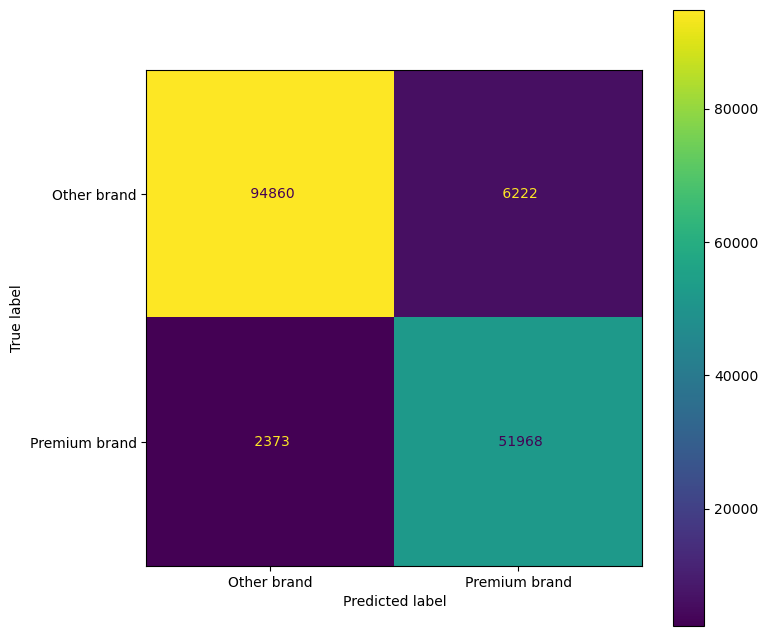

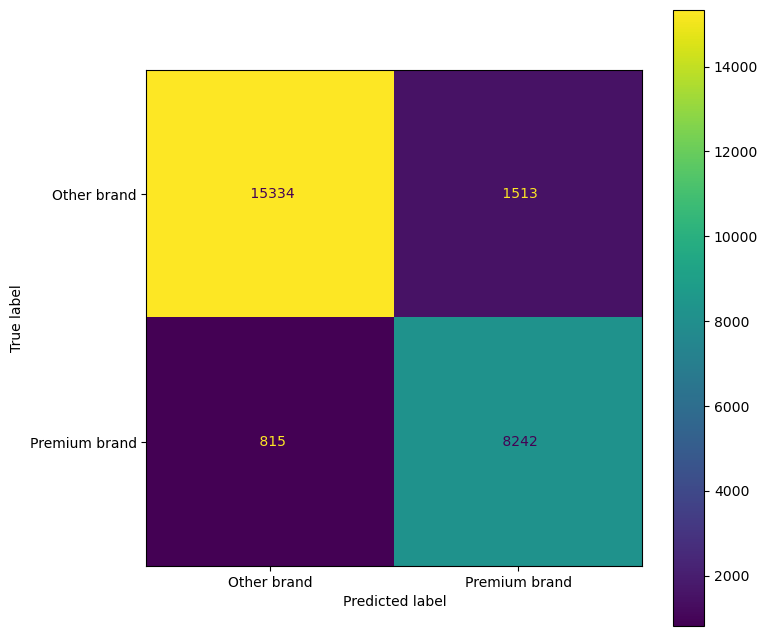

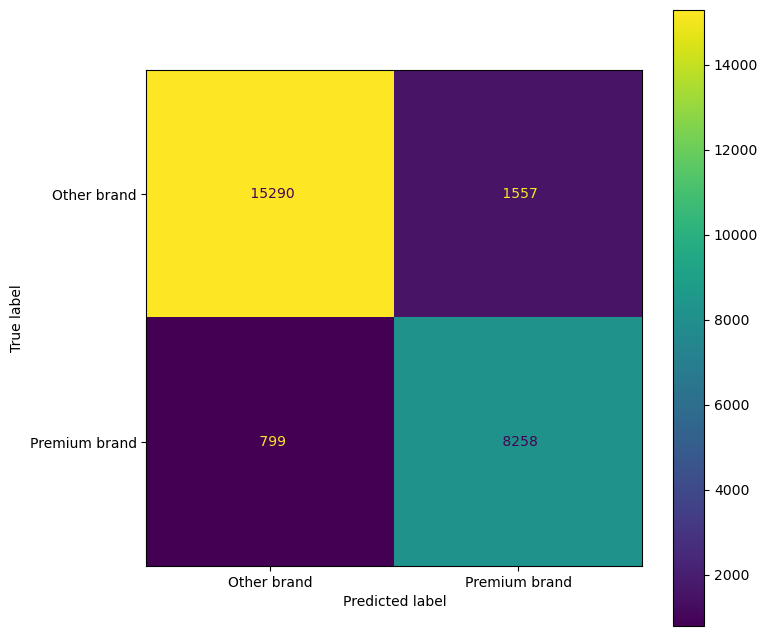

In [42]:
conf_matrix_show(rs_xgb2, X_train_sc, y_train, brands)
conf_matrix_show(rs_xgb2, X_val_sc, y_val, brands)
conf_matrix_show(rs_xgb2, X_test_sc, y_test, brands)

The last XGBClassifier model will choose max_depth from even bigger values than before to check if the model has tendency to overfit.

In [43]:
params = {
    'max_depth': [9,10,12],
    'learning_rate': [0.2, 0.3],
    'reg_lambda': [0.6, 1],
    'reg_alpha': [0, 0.2]
}

fit_params = {
    'early_stopping_rounds': 15, 
    'eval_set' : [[X_val_sc, y_val]],
    'verbose': None
}

rs_xgb3 = RandomizedSearchCV(
    xgb_clf, 
    param_distributions=params,
    cv=cv,
    verbose=3
)
    
start = time.time()
rs_xgb3.fit(X_train_sc, y_train, **fit_params)
rs_xgb3_train_pred = rs_xgb3.predict(X_train_sc)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins} mins and {seconds} s.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.2, max_depth=10, reg_alpha=0, reg_lambda=1;, score=0.904 total time=  20.7s
[CV 2/5] END learning_rate=0.2, max_depth=10, reg_alpha=0, reg_lambda=1;, score=0.904 total time=  21.3s
[CV 3/5] END learning_rate=0.2, max_depth=10, reg_alpha=0, reg_lambda=1;, score=0.908 total time=  37.1s
[CV 4/5] END learning_rate=0.2, max_depth=10, reg_alpha=0, reg_lambda=1;, score=0.907 total time=  26.5s
[CV 5/5] END learning_rate=0.2, max_depth=10, reg_alpha=0, reg_lambda=1;, score=0.905 total time=  28.6s
[CV 1/5] END learning_rate=0.2, max_depth=12, reg_alpha=0.2, reg_lambda=0.6;, score=0.909 total time=  38.4s
[CV 2/5] END learning_rate=0.2, max_depth=12, reg_alpha=0.2, reg_lambda=0.6;, score=0.909 total time=  24.7s
[CV 3/5] END learning_rate=0.2, max_depth=12, reg_alpha=0.2, reg_lambda=0.6;, score=0.907 total time=  18.6s
[CV 4/5] END learning_rate=0.2, max_depth=12, reg_alpha=0.2, reg_lambda=0.6;, score=0.9

This time differences between training and evaluation sets are higher (about 0.05-0.06). Model's fitting to training set is great. Precision and recall in detecting true positives slightly rise. This model also is greedy for param setting - pretty high max_depth and smaller reg_lambda show that model tends to be non conservative.

In [44]:
print(f"XGBClassifier best params adjusted by RandomizedSearchCV: {rs_xgb3.best_params_}.")
print(f"Best score of this setting: {rs_xgb3.best_score_}.")

rs_xgb3_val_pred = rs_xgb3.predict(X_val_sc)
rs_xgb3_test_pred = rs_xgb3.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, rs_xgb3_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, rs_xgb3_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rs_xgb3_test_pred)}')

XGBClassifier best params adjusted by RandomizedSearchCV: {'reg_lambda': 0.6, 'reg_alpha': 0.2, 'max_depth': 12, 'learning_rate': 0.3}.
Best score of this setting: 0.9094278116340003.
Training metrics:

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    101082
           1       0.91      0.97      0.94     54341

    accuracy                           0.96    155423
   macro avg       0.95      0.96      0.95    155423
weighted avg       0.96      0.96      0.96    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     16847
           1       0.85      0.91      0.88      9057

    accuracy                           0.91     25904
   macro avg       0.90      0.91      0.91     25904
weighted avg       0.92      0.91      0.91     25904

_____________________________________________________

Test metrics

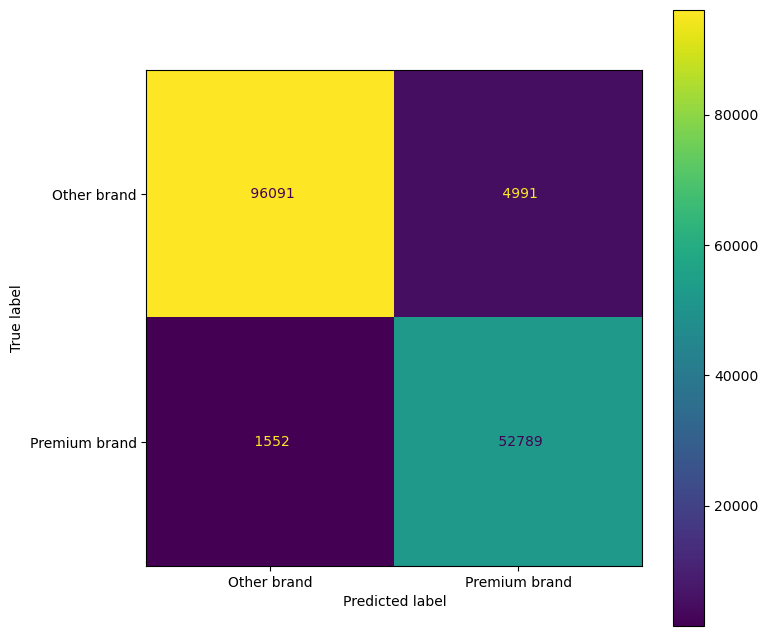

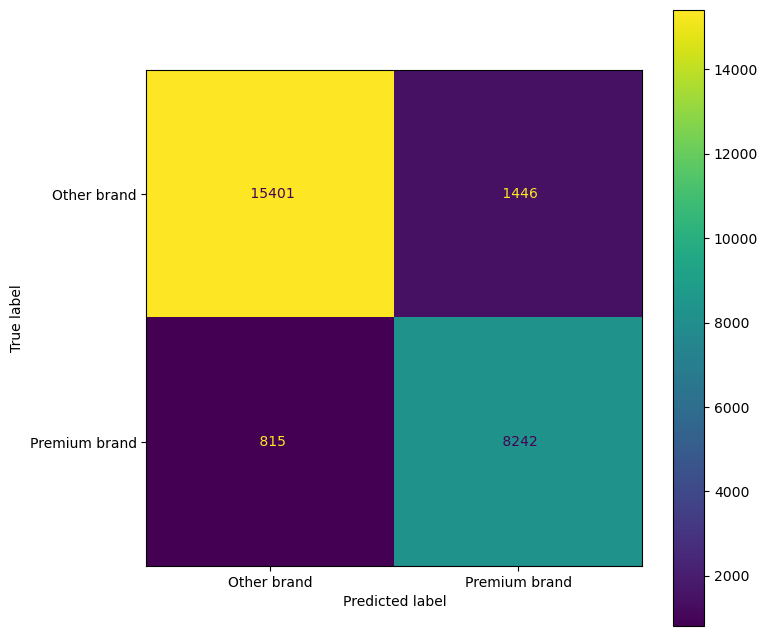

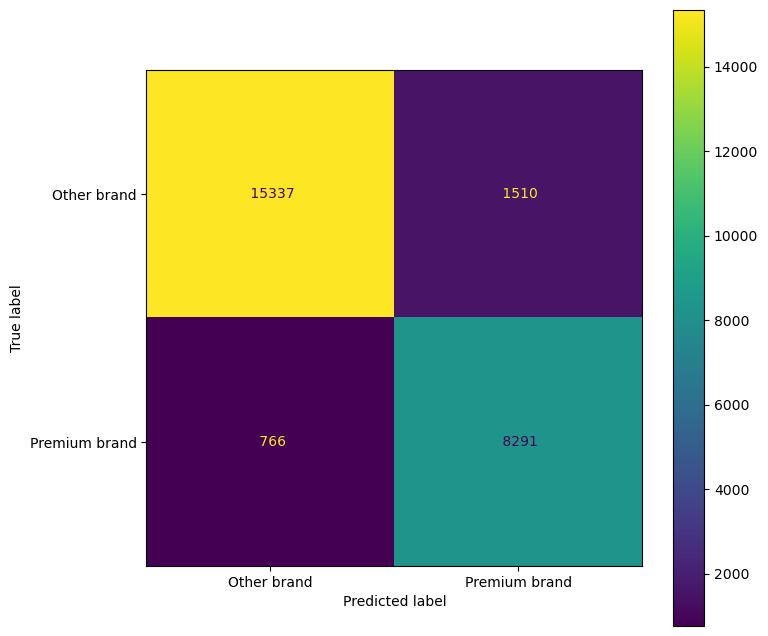

In [45]:
conf_matrix_show(rs_xgb3, X_train_sc, y_train, brands)
conf_matrix_show(rs_xgb3, X_val_sc, y_val, brands)
conf_matrix_show(rs_xgb3, X_test_sc, y_test, brands)

The second model turned out to be the best one. We'll train it with params adjusted by RSCV.

In [75]:
xgb_model4 = xgb.XGBClassifier(
    max_depth=8,  
    n_estimators=400,
    learning_rate=0.3, 
    objective='binary:logistic', 
    eval_metric='error',
    reg_lambda = 0.6, 
    reg_alpha = 0.2, 
    scale_pos_weight = imbalance
)

start = time.time()
xgb_model4.fit(
    X_train_sc, y_train,
    eval_set=[(X_train_sc, y_train), (X_val_sc, y_val)], 
    early_stopping_rounds=15,
    verbose=10
)

xgb_model4_train_pred = xgb_model4.predict(X_train_sc)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins} mins and {seconds} s.")

[0]	validation_0-error:0.16047	validation_1-error:0.16206
[10]	validation_0-error:0.12752	validation_1-error:0.13349
[20]	validation_0-error:0.11079	validation_1-error:0.11631
[30]	validation_0-error:0.09959	validation_1-error:0.10651
[40]	validation_0-error:0.09388	validation_1-error:0.10381
[50]	validation_0-error:0.09018	validation_1-error:0.10199
[60]	validation_0-error:0.08721	validation_1-error:0.10037
[70]	validation_0-error:0.08289	validation_1-error:0.09925
[80]	validation_0-error:0.07986	validation_1-error:0.09809
[90]	validation_0-error:0.07726	validation_1-error:0.09767
[100]	validation_0-error:0.07521	validation_1-error:0.09717
[110]	validation_0-error:0.07332	validation_1-error:0.09663
[120]	validation_0-error:0.07041	validation_1-error:0.09597
[130]	validation_0-error:0.06868	validation_1-error:0.09489
[140]	validation_0-error:0.06644	validation_1-error:0.09385
[150]	validation_0-error:0.06419	validation_1-error:0.09346
[160]	validation_0-error:0.06199	validation_1-error

This model is optimal. Validation and test sets have the biggest F1 scores of the premium brands. The decrease of metrics is nominal in evaluation sets and the recall for true positives is still pretty good.

In [76]:
xgb_model4_val_pred = xgb_model4.predict(X_val_sc)
xgb_model4_test_pred = xgb_model4.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, xgb_model4_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, xgb_model4_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, xgb_model4_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    101082
           1       0.89      0.96      0.92     54341

    accuracy                           0.94    155423
   macro avg       0.93      0.95      0.94    155423
weighted avg       0.95      0.94      0.95    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     16847
           1       0.84      0.91      0.88      9057

    accuracy                           0.91     25904
   macro avg       0.90      0.91      0.90     25904
weighted avg       0.91      0.91      0.91     25904

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     16847
           1       0.84      0.91      0.88      9057

    accuracy     

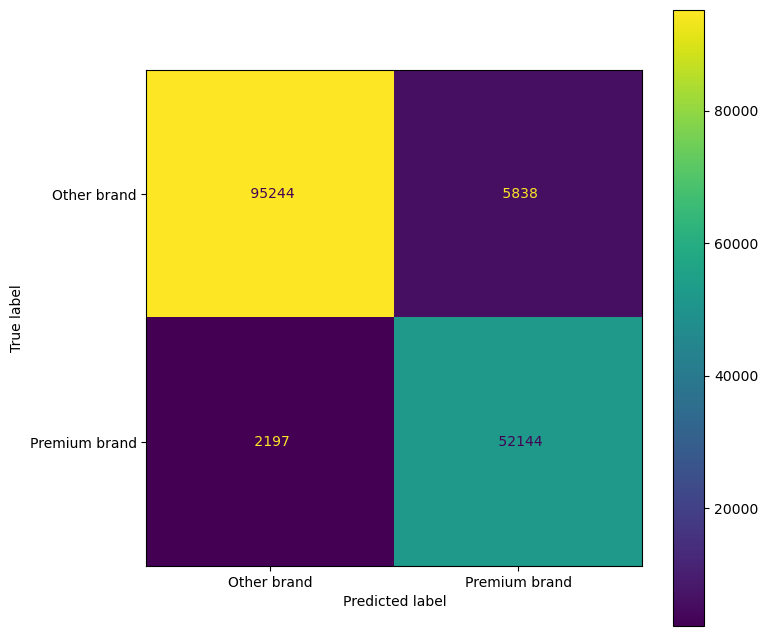

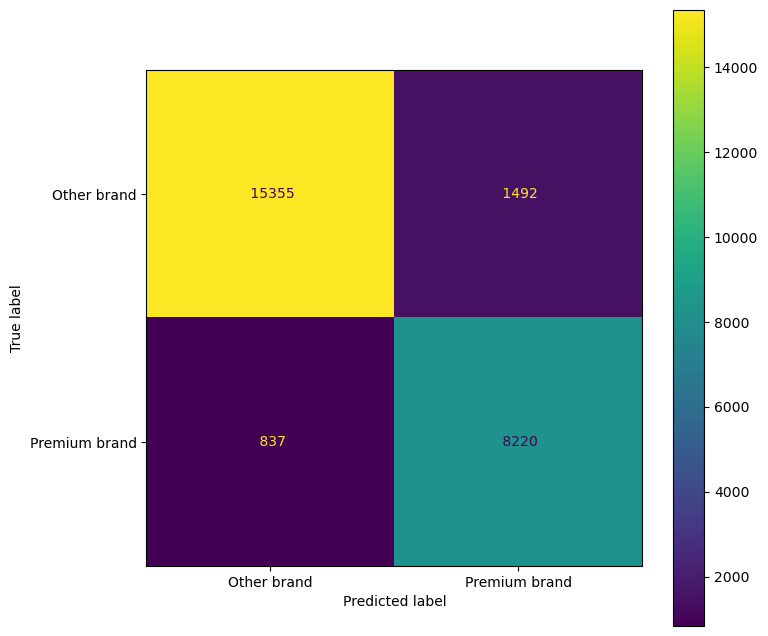

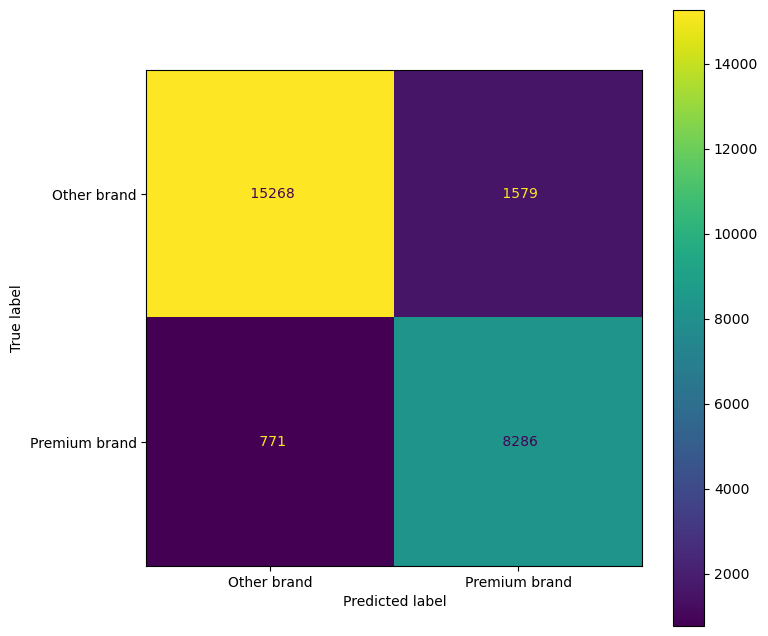

In [48]:
conf_matrix_show(xgb_model4, X_train_sc, y_train, brands)
conf_matrix_show(xgb_model4, X_val_sc, y_val, brands)
conf_matrix_show(xgb_model4, X_test_sc, y_test, brands)

Model stopped having visible learning progress at about 160th estimator.

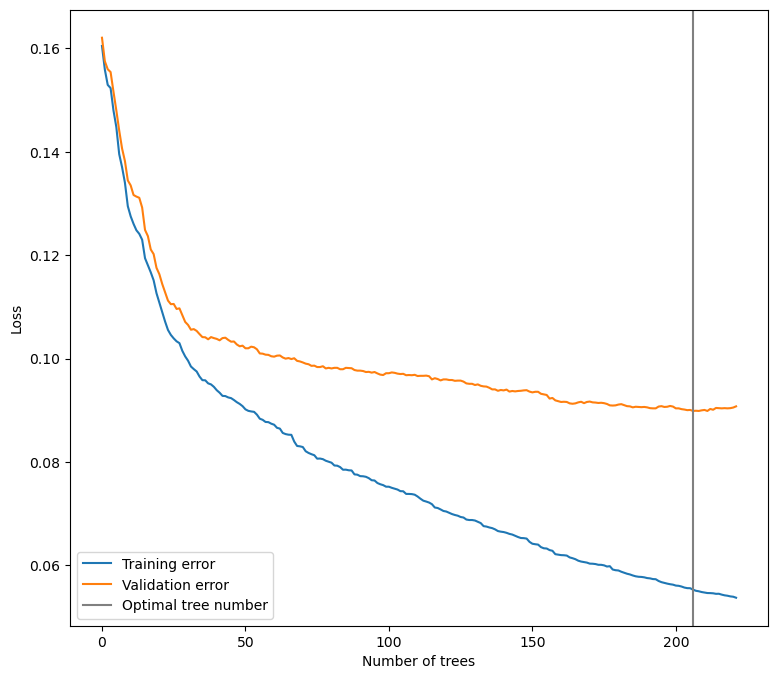

In [77]:
results = xgb_model4.evals_result()

plt.figure(figsize=(9,8))
plt.plot(results["validation_0"]["error"], label="Training error")
plt.plot(results["validation_1"]["error"], label="Validation error")
plt.axvline(xgb_model4.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

The biggest importances by far, due to the model, have engine power. Quite big is also vehicle type's rate.

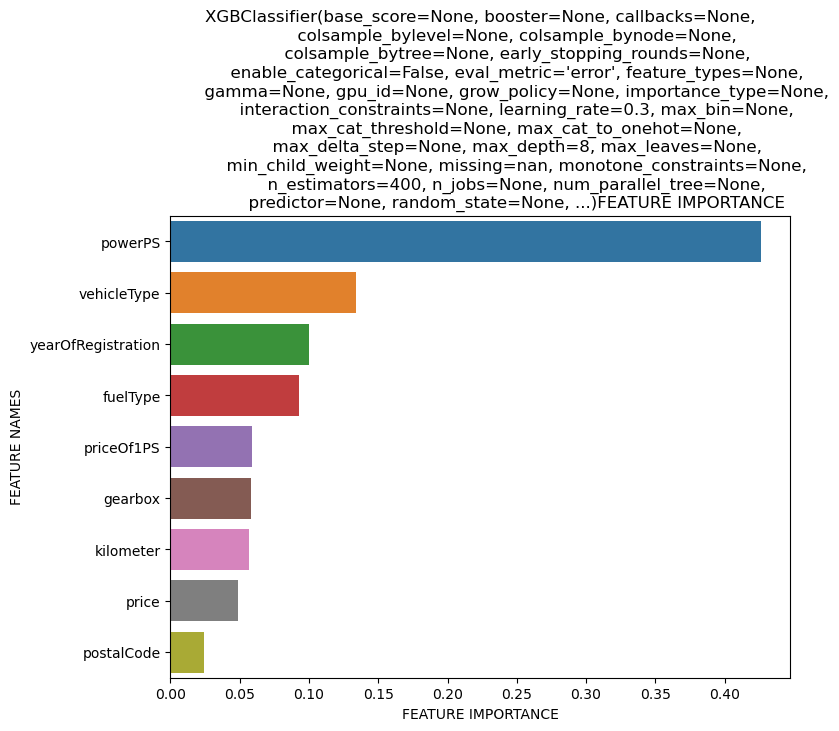

In [78]:
xgb_importances = xgb_model4.feature_importances_
xgb_features = X.columns

def plot_feature_importance(importance, names, model_type):

    # 1. Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # 2. Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # 3. Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # 4. Define size of bar plot
    plt.figure(figsize=(8, 6))
    # 5. Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # 6. Add chart labels
    plt.title(f'{model_type}' + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(xgb_importances, xgb_features, xgb_model4)

## Balanced Random Forest Classifier.

Now we'll create the BalancedRFC model. RandomForestClassifier is probably the most powerful Scikit-learn ensemble classifier. Like we can read in documentation, it's a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. BalancedRFC from Imbalanced-learn module is its variant created especially for imbalanced sets; it randomly under-samples each boostrap sample to balance it.

For BRFC we'll adjust params:
- max_depth,
- min_samples_split - the minimum number of samples required to split an internal node,
- min_samples_leaf - the minimum number of samples required to be at a leaf node,
- n_estimators - the number of trees in the forest.

RandomForestClassifiers don't need standarized data.

In [53]:
brfc_clf = BalancedRandomForestClassifier()
params = {
    'max_depth': [6,7,8],
    'min_samples_split': [2,4,8],
    'min_samples_leaf': [1,2,4],
    'n_estimators': [100,200]
}
              
rs_brfc = RandomizedSearchCV(
    brfc_clf, 
    param_distributions=params,
    cv=cv,
    verbose=3
)

start = time.time()
rs_brfc.fit(X_train, y_train)
rs_brfc_train_pred = rs_brfc.predict(X_train)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins}:{seconds} mins.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.828 total time=  10.7s
[CV 2/5] END max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.829 total time=   8.9s
[CV 3/5] END max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.822 total time=  11.4s
[CV 4/5] END max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.827 total time=  11.4s
[CV 5/5] END max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.821 total time=  10.9s
[CV 1/5] END max_depth=8, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.833 total time=  25.2s
[CV 2/5] END max_depth=8, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.836 total time=  24.8s
[CV 3/5] END max_depth=8, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.829 total time=  23.4s
[CV

That model is has worse metrics than XGBClassifier. Number of estimators doesn't have visible influence for the metrics, but lenghtens the process of training. Metrics are exactly the same for each set, so the model could be tuned more.

In [54]:
print(f"BRFClassifier best params adjusted by RandomizedSearchCV: {rs_brfc.best_params_}.")
print(f"Best score of this setting: {rs_brfc.best_score_}.")

rs_brfc_val_pred = rs_brfc.predict(X_val)
rs_brfc_test_pred = rs_brfc.predict(X_test)
print(f'Training metrics:\n\n{classification_report(y_train, rs_brfc_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, rs_brfc_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rs_brfc_test_pred)}')

BRFClassifier best params adjusted by RandomizedSearchCV: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 8}.
Best score of this setting: 0.8319103198694279.
Training metrics:

              precision    recall  f1-score   support

           0       0.91      0.82      0.87    101082
           1       0.72      0.85      0.78     54341

    accuracy                           0.83    155423
   macro avg       0.82      0.84      0.82    155423
weighted avg       0.85      0.83      0.84    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.91      0.82      0.86     16847
           1       0.72      0.85      0.78      9057

    accuracy                           0.83     25904
   macro avg       0.82      0.84      0.82     25904
weighted avg       0.85      0.83      0.84     25904

_____________________________________________________

Test

This model makes about a half more false negative errors and about two times more false positive errors.

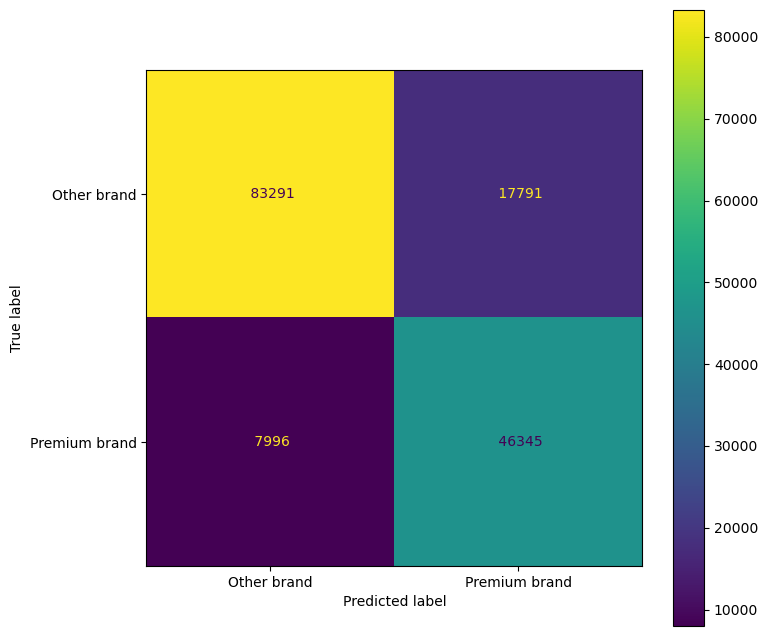

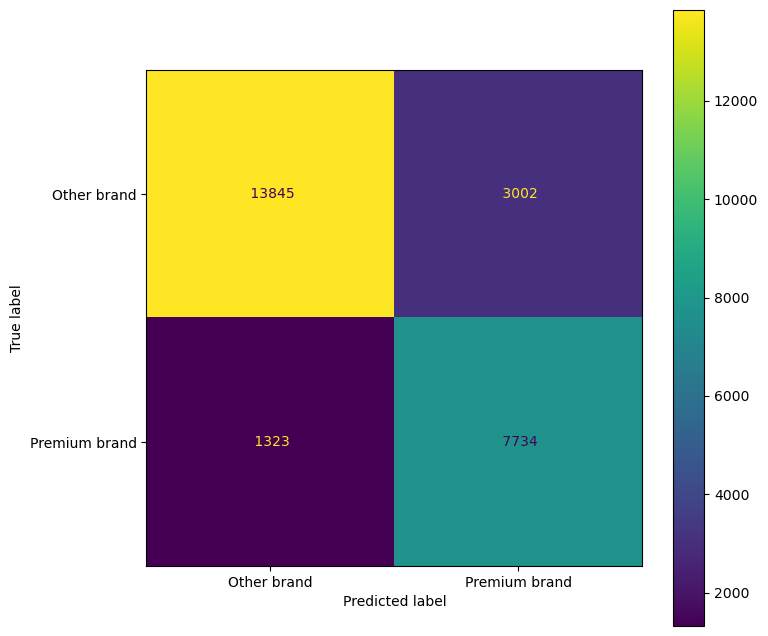

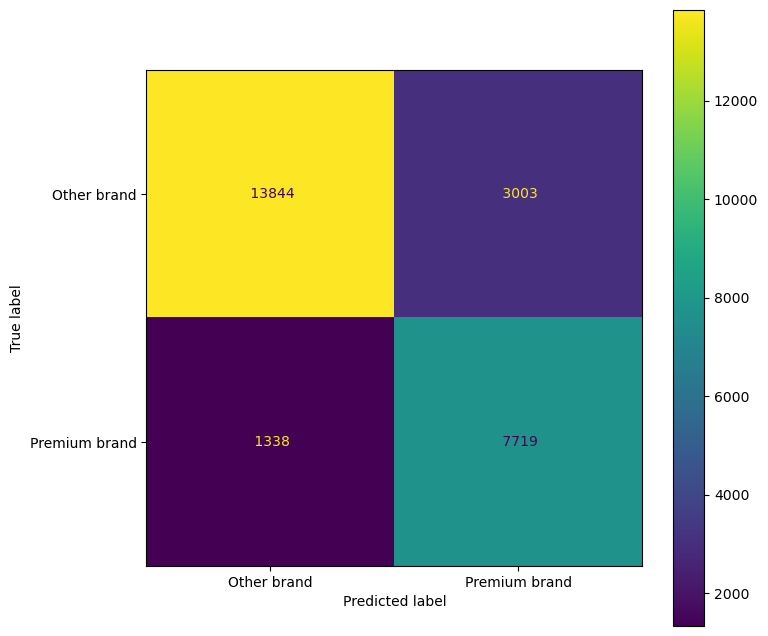

In [55]:
conf_matrix_show(rs_brfc, X_train, y_train, brands)
conf_matrix_show(rs_brfc, X_val, y_val, brands)
conf_matrix_show(rs_brfc, X_test, y_test, brands)

This time we'll check how max_depth tuning affects on model scores. We'll set steady number of estimators equal to 100 - it shouldn't have negative impact on efficiency, but will make model work faster.

In [56]:
params = {
    'max_depth': [9, 10, 12],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100]
}
              
rs_brfc2 = RandomizedSearchCV(
    brfc_clf, 
    param_distributions=params,
    cv=cv,
    verbose=3
)

start = time.time()
rs_brfc2.fit(X_train, y_train)
rs_brfc2_train_pred = rs_brfc2.predict(X_train)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins}:{seconds} mins.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=12, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.867 total time=  14.0s
[CV 2/5] END max_depth=12, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.871 total time=  14.1s
[CV 3/5] END max_depth=12, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.870 total time=  14.2s
[CV 4/5] END max_depth=12, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.871 total time=  14.8s
[CV 5/5] END max_depth=12, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.868 total time=  14.8s
[CV 1/5] END max_depth=12, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.865 total time=  14.2s
[CV 2/5] END max_depth=12, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.870 total time=  14.4s
[CV 3/5] END max_depth=12, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.871 total time=  1

Metrics rose and they're similar on every set. Model is not too precise, when it comes to positives detection - a lot of false positives causes not impressive precision and F1 score rates.

In [57]:
print(f"BRFClassifier best params adjusted by RandomizedSearchCV: {rs_brfc2.best_params_}.")
print(f"Best score of this setting: {rs_brfc2.best_score_}.")

rs_brfc2_val_pred = rs_brfc2.predict(X_val)
rs_brfc2_test_pred = rs_brfc2.predict(X_test)
print(f'Training metrics:\n\n{classification_report(y_train, rs_brfc2_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, rs_brfc2_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rs_brfc2_test_pred)}')

BRFClassifier best params adjusted by RandomizedSearchCV: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 12}.
Best score of this setting: 0.8692535837711082.
Training metrics:

              precision    recall  f1-score   support

           0       0.95      0.87      0.91    101082
           1       0.79      0.91      0.85     54341

    accuracy                           0.89    155423
   macro avg       0.87      0.89      0.88    155423
weighted avg       0.89      0.89      0.89    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.94      0.86      0.90     16847
           1       0.78      0.89      0.83      9057

    accuracy                           0.87     25904
   macro avg       0.86      0.88      0.86     25904
weighted avg       0.88      0.87      0.87     25904

_____________________________________________________

Tes

As we can see, it's still a lot to improve in detecting premium brands.

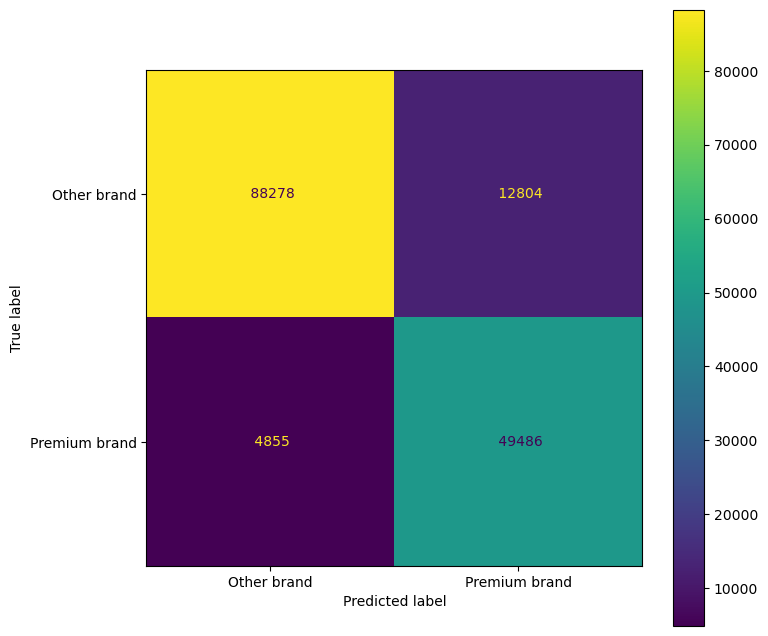

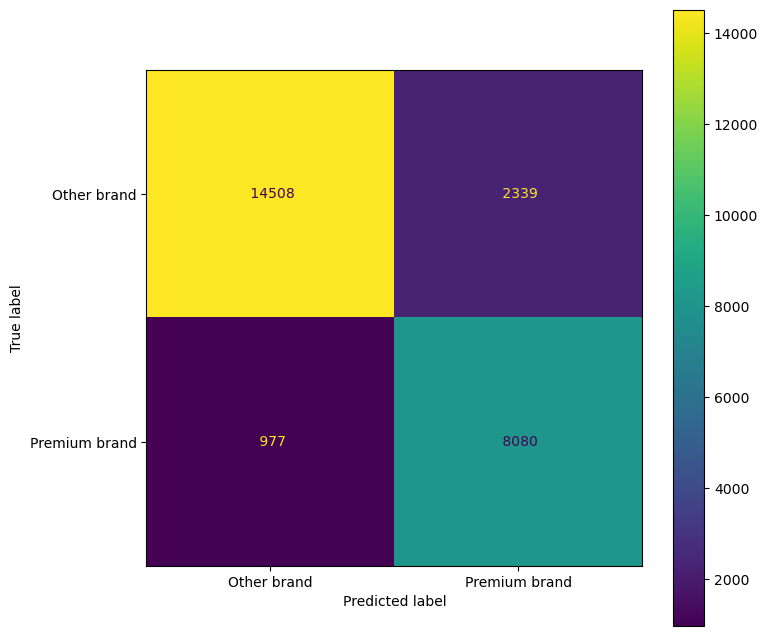

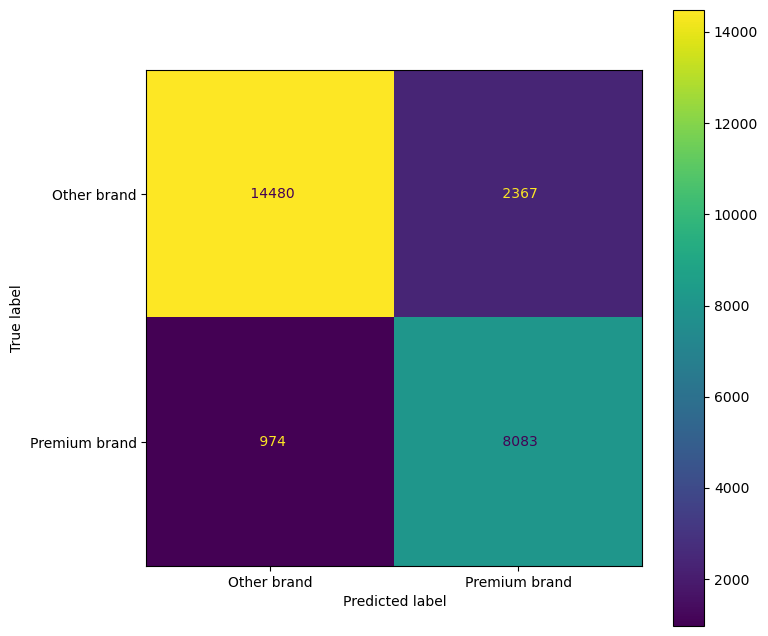

In [58]:
conf_matrix_show(rs_brfc2, X_train, y_train, brands)
conf_matrix_show(rs_brfc2, X_val, y_val, brands)
conf_matrix_show(rs_brfc2, X_test, y_test, brands)

Because model demands to have deeper trees in ensemble, we'll try to make a model with large values of max_depth.

In [59]:
params = {
    'max_depth': [14, 16, 18, 20],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100]
}
              
rs_brfc3 = RandomizedSearchCV(
    brfc_clf, 
    param_distributions=params,
    cv=cv,
    verbose=3
)

start = time.time()
rs_brfc3.fit(X_train, y_train)
rs_brfc3_train_pred = rs_brfc3.predict(X_train)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins}:{seconds} mins.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.891 total time=  18.7s
[CV 2/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.895 total time=  16.9s
[CV 3/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.895 total time=  16.8s
[CV 4/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.894 total time=  16.9s
[CV 5/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.891 total time=  16.4s
[CV 1/5] END max_depth=14, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.878 total time=  14.5s
[CV 2/5] END max_depth=14, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.882 total time=  15.2s
[CV 3/5] END max_depth=14, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.882 total time=  1

Model has the best metrics, but also is tend to overfit - metrics loss in evaluation sets is about 0.05. RSCV verbosity tells us that the depth of trees starts to have no meaning in generalizing.

In [60]:
print(f"BRFClassifier best params adjusted by RandomizedSearchCV: {rs_brfc3.best_params_}.")
print(f"Best score of this setting: {rs_brfc3.best_score_}.")

rs_brfc3_val_pred = rs_brfc3.predict(X_val)
rs_brfc3_test_pred = rs_brfc3.predict(X_test)
print(f'Training metrics:\n\n{classification_report(y_train, rs_brfc3_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, rs_brfc3_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rs_brfc3_test_pred)}')

BRFClassifier best params adjusted by RandomizedSearchCV: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 18}.
Best score of this setting: 0.8936708133188507.
Training metrics:

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    101082
           1       0.89      0.98      0.93     54341

    accuracy                           0.95    155423
   macro avg       0.94      0.96      0.95    155423
weighted avg       0.96      0.95      0.95    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     16847
           1       0.82      0.92      0.86      9057

    accuracy                           0.90     25904
   macro avg       0.88      0.90      0.89     25904
weighted avg       0.90      0.90      0.90     25904

_____________________________________________________

Tes

Model's recall is higher than in XGBClassifier instances, but precision is still much weaker.

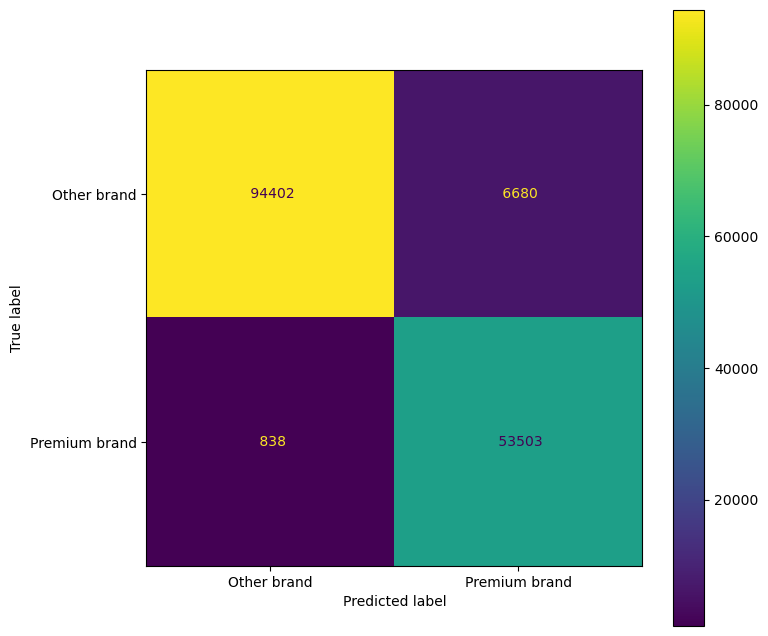

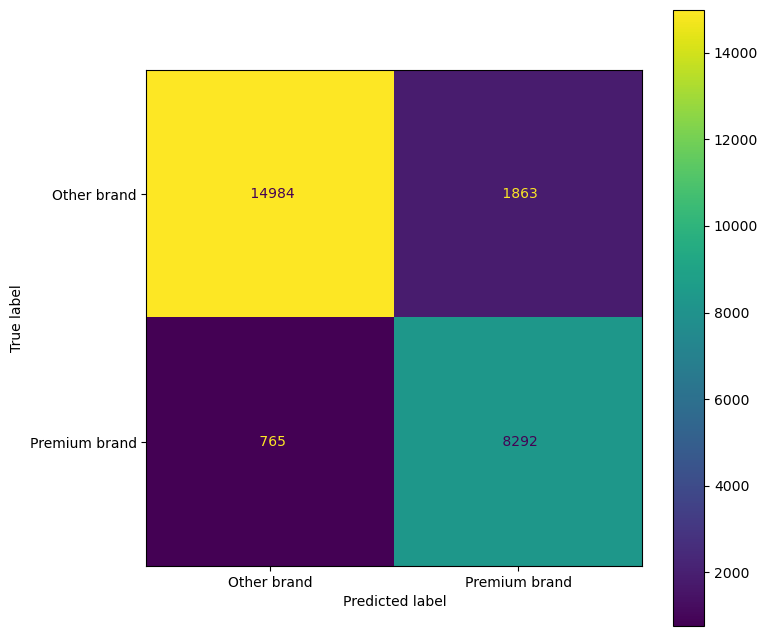

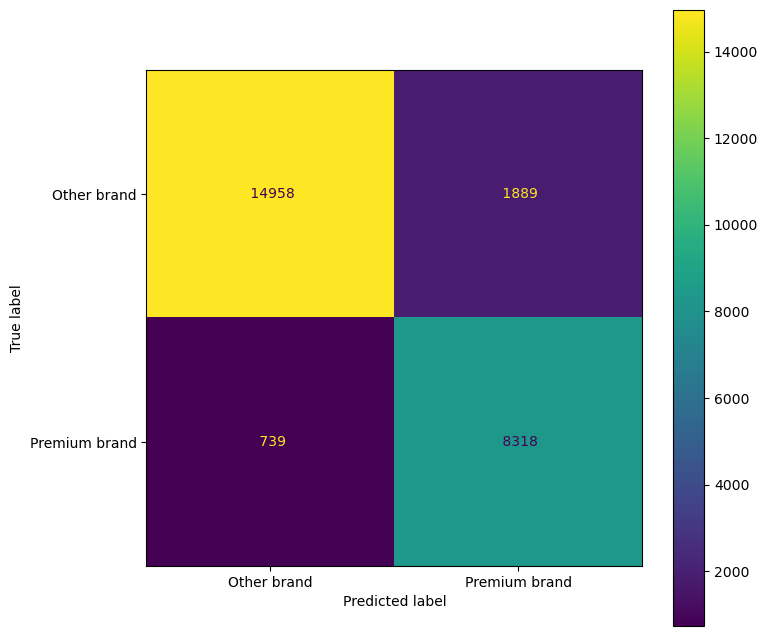

In [61]:
conf_matrix_show(rs_brfc3, X_train, y_train, brands)
conf_matrix_show(rs_brfc3, X_val, y_val, brands)
conf_matrix_show(rs_brfc3, X_test, y_test, brands)

Penultimate instance of BRFC with use of RSCV will have the deepest trees. We'll see if the model is keen to improve metrics, or is it already overfitted.

In [62]:
params = {
    'max_depth': [25, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100]
}
              
rs_brfc4 = RandomizedSearchCV(
    brfc_clf, 
    param_distributions=params,
    cv=cv,
    verbose=3
)

start = time.time()
rs_brfc4.fit(X_train, y_train)
rs_brfc4_train_pred = rs_brfc4.predict(X_train)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins}:{seconds} mins.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=100;, score=0.891 total time=  17.8s
[CV 2/5] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=100;, score=0.895 total time=  17.7s
[CV 3/5] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=100;, score=0.895 total time=  18.5s
[CV 4/5] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=100;, score=0.895 total time=  17.0s
[CV 5/5] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=100;, score=0.891 total time=  16.8s
[CV 1/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.897 total time=  17.3s
[CV 2/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.900 total time=  17.6s
[CV 3/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.899 total time=  1

Model with 30 max_depth is almost perfectly fitted on training set, but improval on evaluation sets are merely visible.

In [63]:
print(f"BRFClassifier best params adjusted by RandomizedSearchCV: {rs_brfc4.best_params_}.")
print(f"Best score of this setting: {rs_brfc4.best_score_}.")

rs_brfc4_val_pred = rs_brfc4.predict(X_val)
rs_brfc4_test_pred = rs_brfc4.predict(X_test)
print(f'Training metrics:\n\n{classification_report(y_train, rs_brfc4_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, rs_brfc4_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rs_brfc4_test_pred)}')

BRFClassifier best params adjusted by RandomizedSearchCV: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 25}.
Best score of this setting: 0.8986636452695169.
Training metrics:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    101082
           1       0.94      1.00      0.97     54341

    accuracy                           0.98    155423
   macro avg       0.97      0.98      0.97    155423
weighted avg       0.98      0.98      0.98    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     16847
           1       0.83      0.91      0.87      9057

    accuracy                           0.90     25904
   macro avg       0.89      0.91      0.90     25904
weighted avg       0.91      0.90      0.90     25904

_____________________________________________________

Tes

Tuning didn't eliminate problems with model's precision.

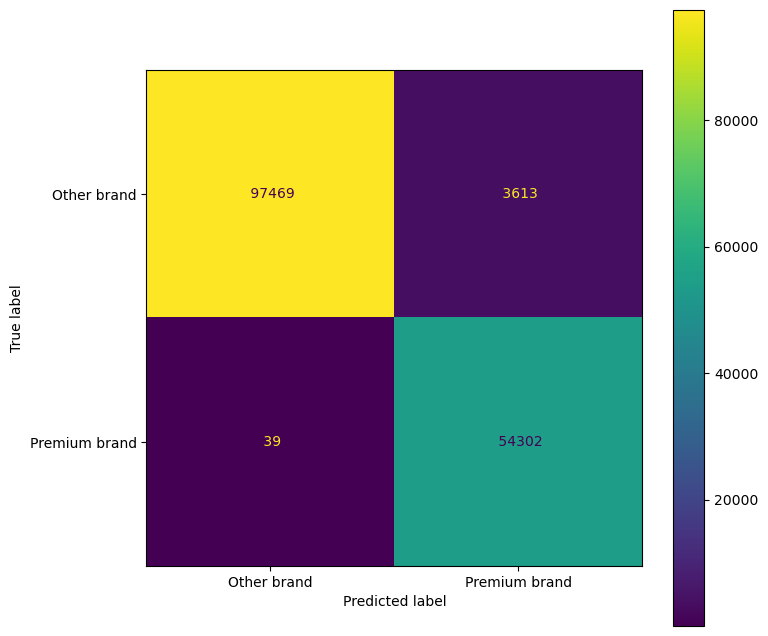

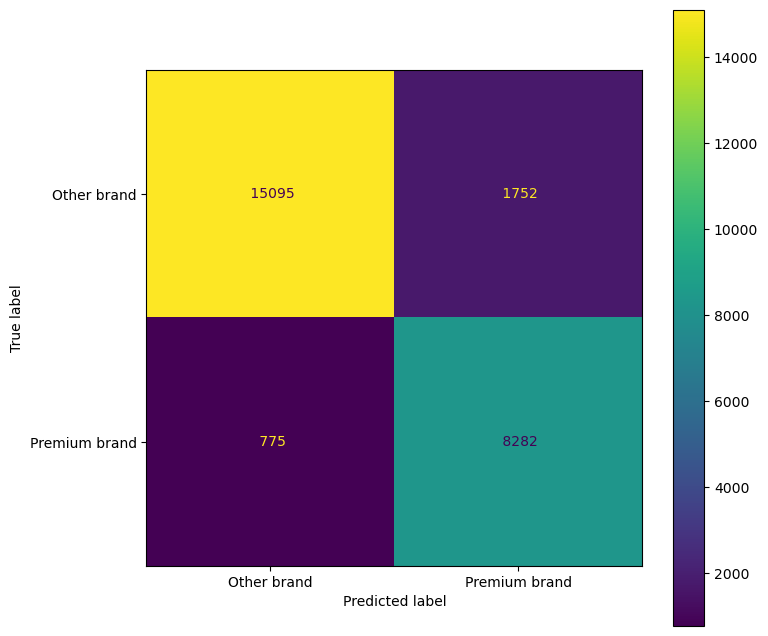

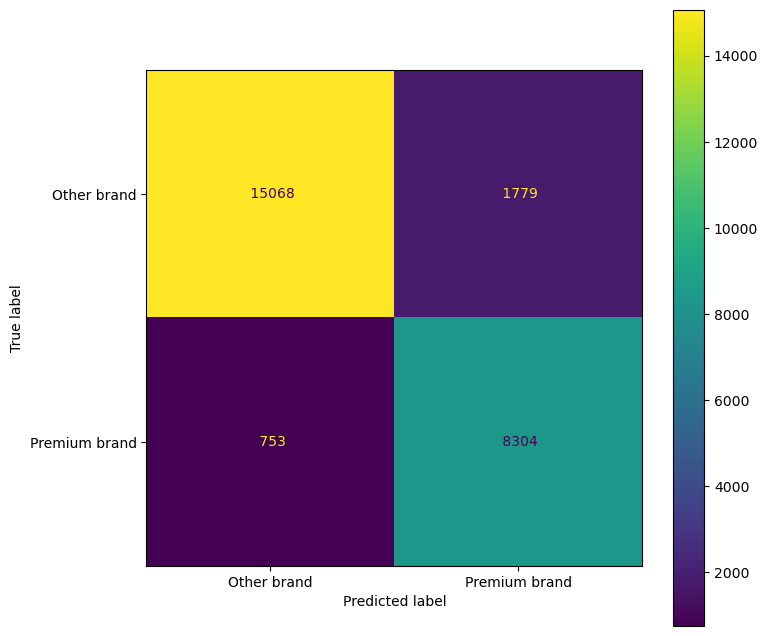

In [64]:
conf_matrix_show(rs_brfc4, X_train, y_train, brands)
conf_matrix_show(rs_brfc4, X_val, y_val, brands)
conf_matrix_show(rs_brfc4, X_test, y_test, brands)

We'll create last instance - with trade-off in max_depth.

In [65]:
brfc5 = BalancedRandomForestClassifier(
    max_depth=18,
    min_samples_split=4,
    min_samples_leaf=1,
    n_estimators=100
)

start = time.time()
brfc5.fit(X_train, y_train)
brfc5_train_pred = brfc5.predict(X_train)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins}:{seconds} mins.")

Training time: 0:25 mins.


Model has slightly worse metrics than XGBClassifier and makes even bigger amount of true positive errors.

In [66]:
brfc5_val_pred = brfc5.predict(X_val)
brfc5_test_pred = brfc5.predict(X_test)
print(f'Training metrics:\n\n{classification_report(y_train, brfc5_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, brfc5_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, brfc5_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    101082
           1       0.88      0.98      0.92     54341

    accuracy                           0.94    155423
   macro avg       0.93      0.95      0.94    155423
weighted avg       0.95      0.94      0.94    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     16847
           1       0.81      0.91      0.86      9057

    accuracy                           0.90     25904
   macro avg       0.88      0.90      0.89     25904
weighted avg       0.90      0.90      0.90     25904

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     16847
           1       0.81      0.92      0.86      9057

    accuracy     

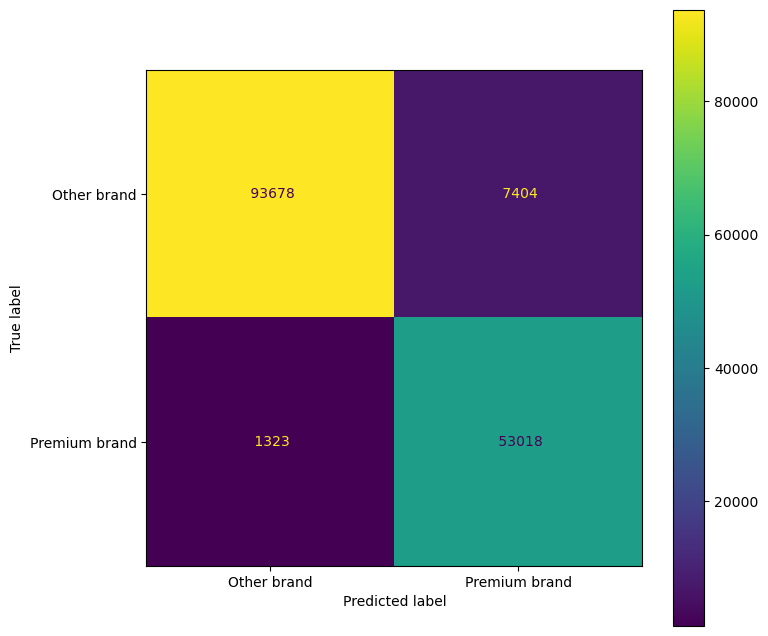

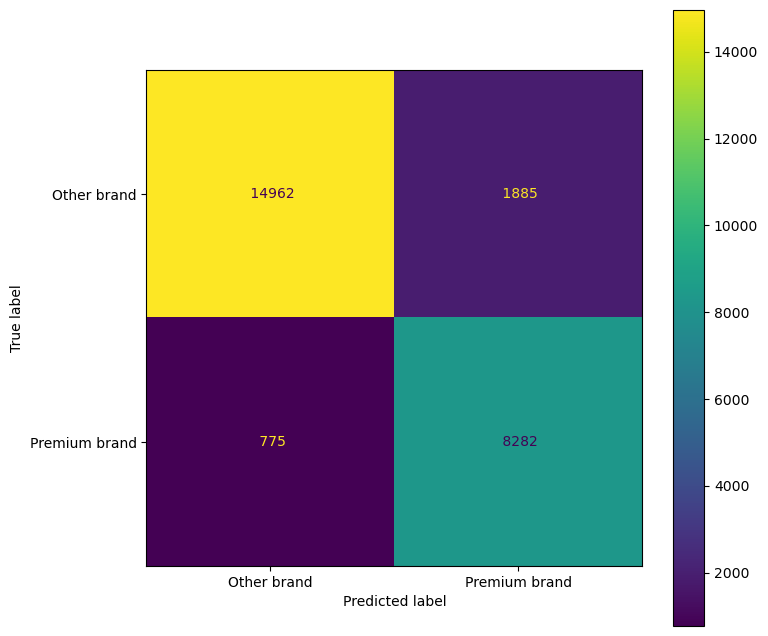

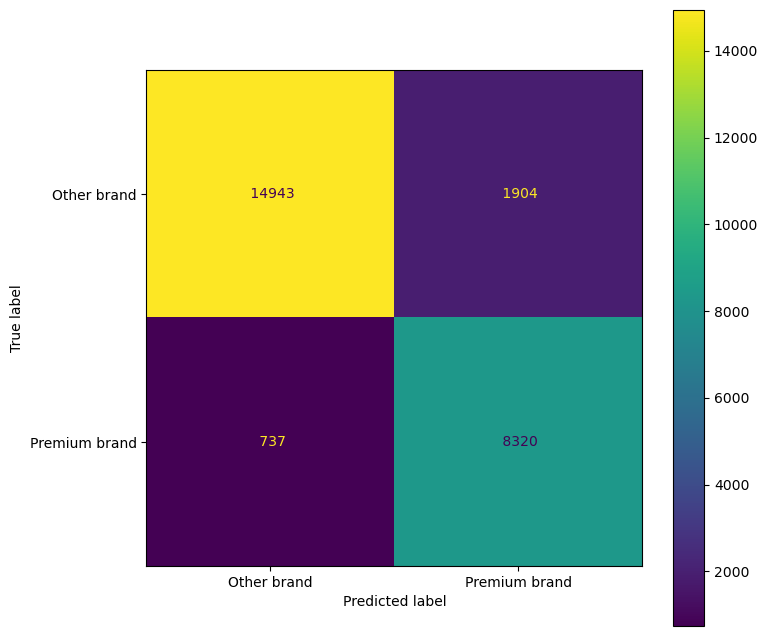

In [67]:
conf_matrix_show(brfc5, X_train, y_train, brands)
conf_matrix_show(brfc5, X_val, y_val, brands)
conf_matrix_show(brfc5, X_test, y_test, brands)

Also this algorithm assigns the biggest importance to engine power. Important to this classifier are also price, car type, price of 1 HP/PS and year of 1st registration.

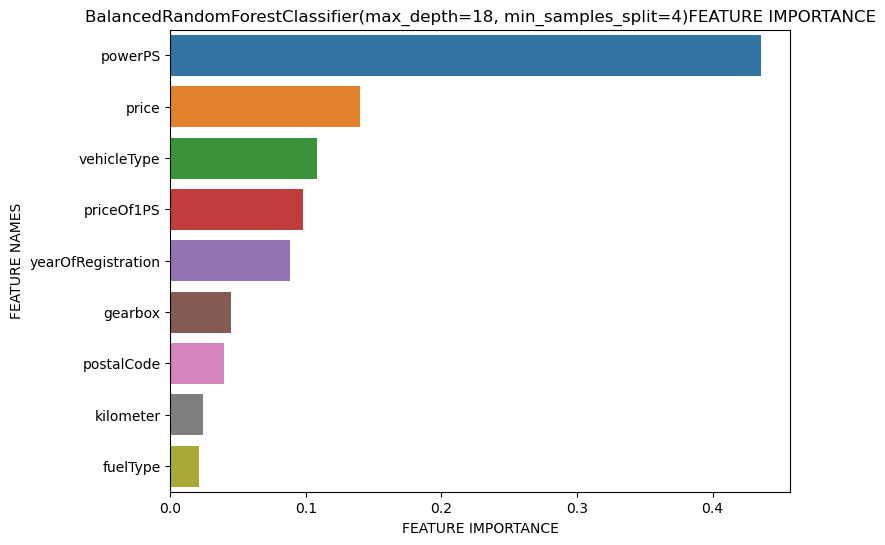

In [79]:
brfc_importances = brfc5.feature_importances_
brfc_features = brfc5.feature_names_in_

plot_feature_importance(brfc_importances, brfc_features, brfc5)

## K-Neighbors Classifier.

K-Neighbors Classifier implements the k-nearest neighbors voting system. As we can read in documentation, classification is computed from a simple majority vote of the nearest neighbors of each point.

This model is fast and easy in implementation, so we'll try to adjust a following params:
- n_neighbors - number of neighbors participating in votes,
- weights - weights of neighbors in voting; if equal to 'distance', weights are the inverse of distance and the closest neighbors are more important; if 'uniform', each neighbor has the same importance,
- metric - distance metric.

In [92]:
knn_clf = KNeighborsClassifier()

params = {
    'n_neighbors': [5, 25, 75], 
    'weights': ['uniform', 'distance'], 
    'metric':['minkowski', 'euclidean', 'manhattan']
}

rs_knn = RandomizedSearchCV(
    knn_clf, 
    param_distributions=params,
    cv=cv,
    verbose=3
)

start = time.time()
rs_knn.fit(X_train, y_train)
rs_knn_train_pred = rs_knn.predict(X_train)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins}:{seconds} mins.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.826 total time=   1.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.830 total time=   0.8s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.824 total time=   1.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.826 total time=   1.1s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.823 total time=   1.2s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.817 total time=   2.2s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.823 total time=   1.5s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.817 total time=   1.5s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.819 total time=   1.5s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.814 tot

Model trains quickly and has almost perfect metrics on training set, but its lack of ability to generalize, particularly premium class, is disqualifying for it. That classifier also has little possibilities to tune.

In [93]:
print(f"KNClassifier best params adjusted by RandomizedSearchCV: {rs_knn.best_params_}.")
print(f"Best score of this setting: {rs_knn.best_score_}.")

rs_knn_val_pred = rs_knn.predict(X_val)
rs_knn_test_pred = rs_knn.predict(X_test)
print(f'Training metrics:\n\n{classification_report(y_train, rs_knn_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, rs_knn_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rs_knn_test_pred)}')

KNClassifier best params adjusted by RandomizedSearchCV: {'weights': 'distance', 'n_neighbors': 25, 'metric': 'manhattan'}.
Best score of this setting: 0.8360088314557199.
Training metrics:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101082
           1       1.00      1.00      1.00     54341

    accuracy                           1.00    155423
   macro avg       1.00      1.00      1.00    155423
weighted avg       1.00      1.00      1.00    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     16847
           1       0.78      0.77      0.78      9057

    accuracy                           0.84     25904
   macro avg       0.83      0.83      0.83     25904
weighted avg       0.84      0.84      0.84     25904

_____________________________________________________

Test metrics:

         

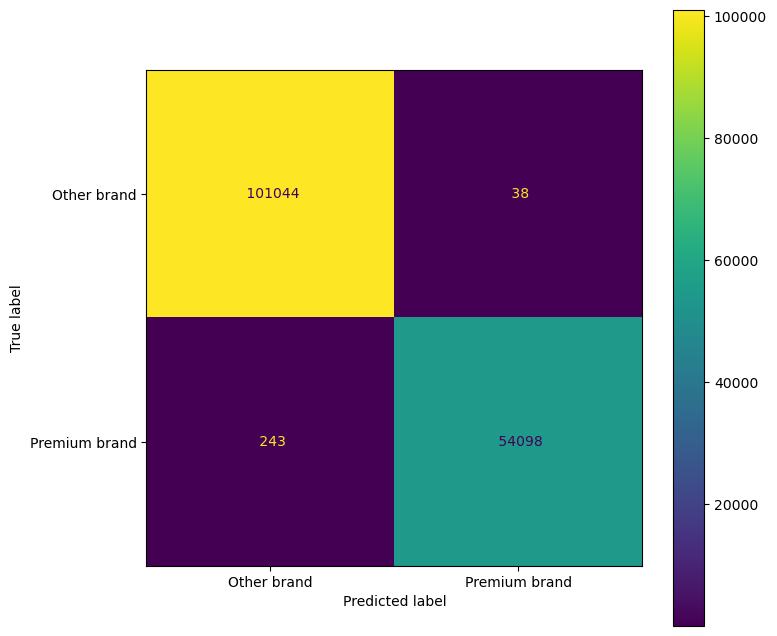

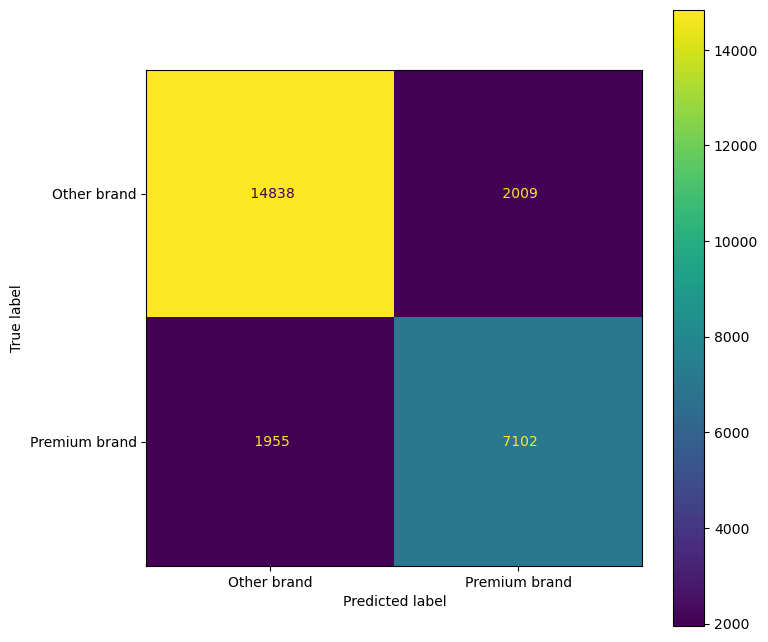

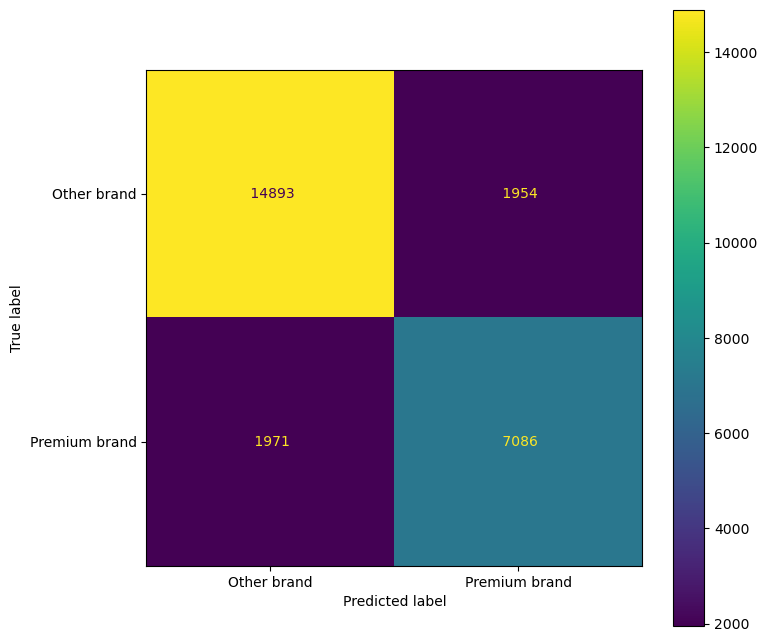

In [87]:
conf_matrix_show(rs_knn, X_train, y_train, brands)
conf_matrix_show(rs_knn, X_val, y_val, brands)
conf_matrix_show(rs_knn, X_test, y_test, brands)

We won't display feature importances - KNN doesn't take them into consideration and doesn't have adequate attributes.

## Complement Naive Bayes.

The last model we'll check is Complement Naive Bayes - it's classifier based on Bayes theorem, adaptation of MultinomialNB, particularly suited for imbalanced data sets. This algorithm uses statistics from the complement of each class to compute the model’s weights.

We'll adjust only two params:
- alpha - additive (Laplace/Lidstone) smoothing parameter,
- norm - whether (True) or not (False) a second normalization of the weights is performed.

In [99]:
cnb_clf = ComplementNB()

params = {
    'alpha': np.linspace(0, 100, num=5),
    'norm': [True, False]
}

rs_cnb = RandomizedSearchCV(
    cnb_clf, 
    param_distributions=params,
    cv=cv,
    verbose=3
)

start = time.time()
rs_cnb.fit(X_train, y_train)
rs_cnb_train_pred = rs_cnb.predict(X_train)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins}:{seconds} mins.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..............alpha=0.0, norm=True;, score=0.660 total time=   0.0s
[CV 2/5] END ..............alpha=0.0, norm=True;, score=0.661 total time=   0.0s
[CV 3/5] END ..............alpha=0.0, norm=True;, score=0.656 total time=   0.0s
[CV 4/5] END ..............alpha=0.0, norm=True;, score=0.660 total time=   0.0s
[CV 5/5] END ..............alpha=0.0, norm=True;, score=0.663 total time=   0.0s
[CV 1/5] END .............alpha=0.0, norm=False;, score=0.694 total time=   0.0s
[CV 2/5] END .............alpha=0.0, norm=False;, score=0.693 total time=   0.0s
[CV 3/5] END .............alpha=0.0, norm=False;, score=0.689 total time=   0.0s
[CV 4/5] END .............alpha=0.0, norm=False;, score=0.695 total time=   0.0s
[CV 5/5] END .............alpha=0.0, norm=False;, score=0.695 total time=   0.0s
[CV 1/5] END .............alpha=25.0, norm=True;, score=0.660 total time=   0.0s
[CV 2/5] END .............alpha=25.0, norm=True;

Fitting of model was instant, but metrics are a little tragedy - about 0.7 on each set. What's the most transparent, when it comes to detect true positives, model's efficiency is only a little better than random.

In [100]:
print(f"ComplementNB best params adjusted by RandomizedSearchCV: {rs_cnb.best_params_}.")
print(f"Best score of this setting: {rs_cnb.best_score_}.")

rs_cnb_val_pred = rs_cnb.predict(X_val)
rs_cnb_test_pred = rs_cnb.predict(X_test)
print(f'Training metrics:\n\n{classification_report(y_train, rs_cnb_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, rs_cnb_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rs_cnb_test_pred)}')

ComplementNB best params adjusted by RandomizedSearchCV: {'norm': False, 'alpha': 0.0}.
Best score of this setting: 0.6930827679166718.
Training metrics:

              precision    recall  f1-score   support

           0       0.76      0.77      0.77    101082
           1       0.56      0.55      0.55     54341

    accuracy                           0.69    155423
   macro avg       0.66      0.66      0.66    155423
weighted avg       0.69      0.69      0.69    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.76      0.77      0.77     16847
           1       0.57      0.55      0.56      9057

    accuracy                           0.69     25904
   macro avg       0.66      0.66      0.66     25904
weighted avg       0.69      0.69      0.69     25904

_____________________________________________________

Test metrics:

              precision    recall  f1-score  

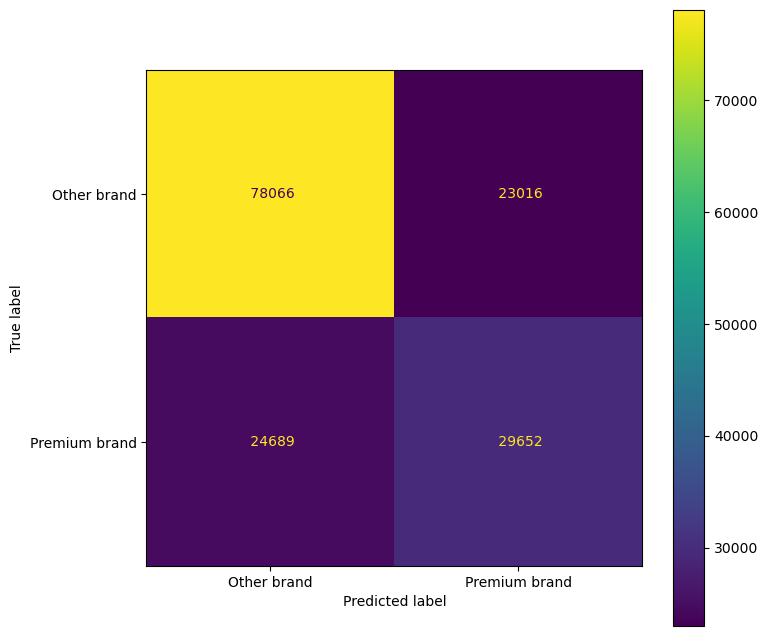

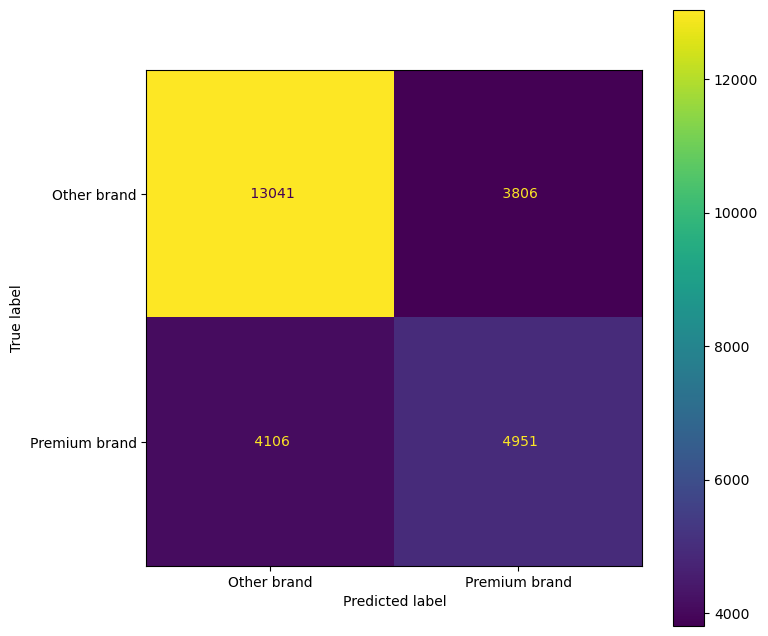

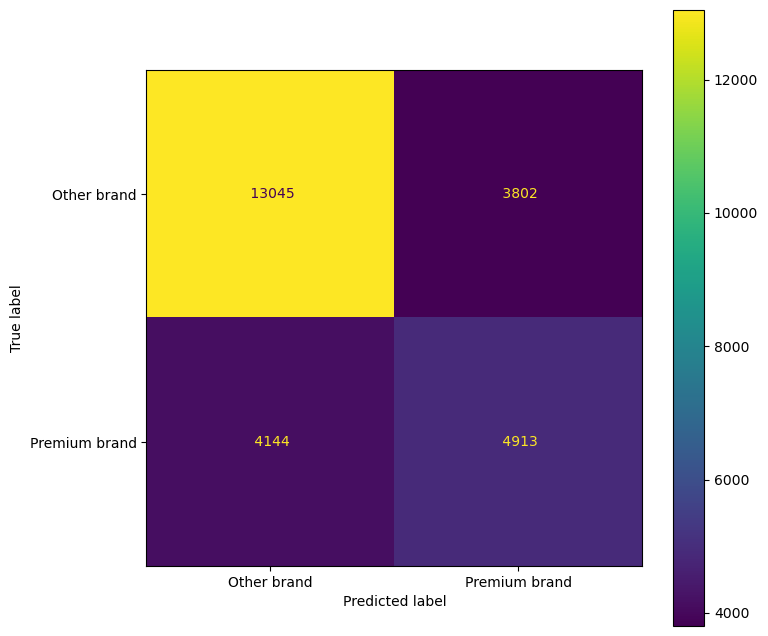

In [101]:
conf_matrix_show(rs_cnb, X_train, y_train, brands)
conf_matrix_show(rs_cnb, X_val, y_val, brands)
conf_matrix_show(rs_cnb, X_test, y_test, brands)

## MLP Classifier.

In multi-layer perceptron we won't adjust params via RandomizedSearchCV because of long training time. The key parameter is the network size and we'll set quite complex network with 6 hidden layers.

In [121]:
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(120,80,40,20,5,2),
    early_stopping=True,
    verbose=True
)

start = time.time()
mlp_clf.fit(X_train_sc, y_train)
mlp_train_pred = mlp_clf.predict(X_train_sc)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins}:{seconds} mins.")

Iteration 1, loss = 0.42946687
Validation score: 0.837483
Iteration 2, loss = 0.36062144
Validation score: 0.845139
Iteration 3, loss = 0.35039917
Validation score: 0.847777
Iteration 4, loss = 0.34516123
Validation score: 0.850222
Iteration 5, loss = 0.34149562
Validation score: 0.852216
Iteration 6, loss = 0.33810461
Validation score: 0.851895
Iteration 7, loss = 0.33623884
Validation score: 0.854533
Iteration 8, loss = 0.33416141
Validation score: 0.855112
Iteration 9, loss = 0.33176957
Validation score: 0.850930
Iteration 10, loss = 0.32964165
Validation score: 0.855691
Iteration 11, loss = 0.32745406
Validation score: 0.855884
Iteration 12, loss = 0.32664631
Validation score: 0.856527
Iteration 13, loss = 0.32452416
Validation score: 0.856849
Iteration 14, loss = 0.32272694
Validation score: 0.857170
Iteration 15, loss = 0.32081614
Validation score: 0.859165
Iteration 16, loss = 0.31973632
Validation score: 0.861288
Iteration 17, loss = 0.31811901
Validation score: 0.862446
Iterat

That's a lot of mistakes for a complex algorithm like this. Model misclassifies about 20% of premium cars, which is unacceptable.

In [122]:
mlp_val_pred = mlp_clf.predict(X_val_sc)
mlp_test_pred = mlp_clf.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, mlp_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, mlp_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, mlp_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.89      0.90      0.90    101082
           1       0.82      0.80      0.81     54341

    accuracy                           0.87    155423
   macro avg       0.86      0.85      0.85    155423
weighted avg       0.87      0.87      0.87    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.89      0.90      0.90     16847
           1       0.81      0.79      0.80      9057

    accuracy                           0.86     25904
   macro avg       0.85      0.85      0.85     25904
weighted avg       0.86      0.86      0.86     25904

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.89      0.90      0.90     16847
           1       0.81      0.80      0.81      9057

    accuracy     

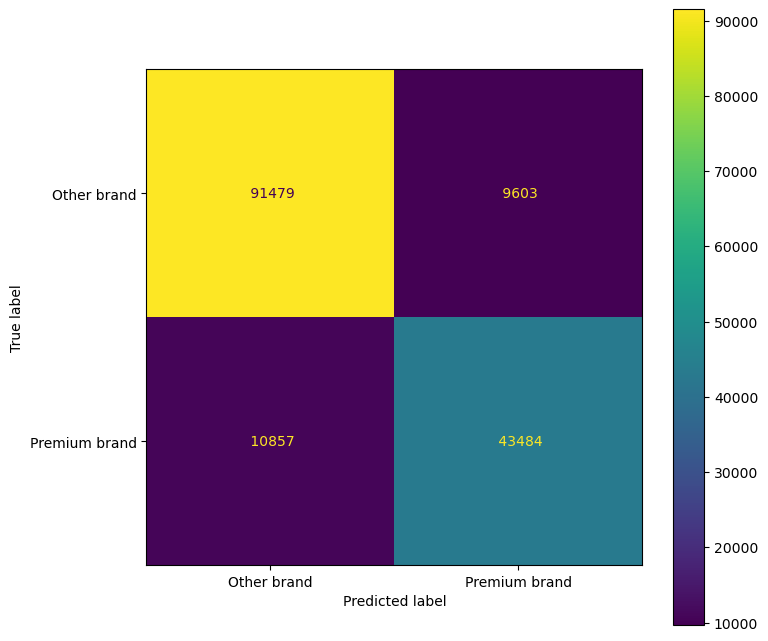

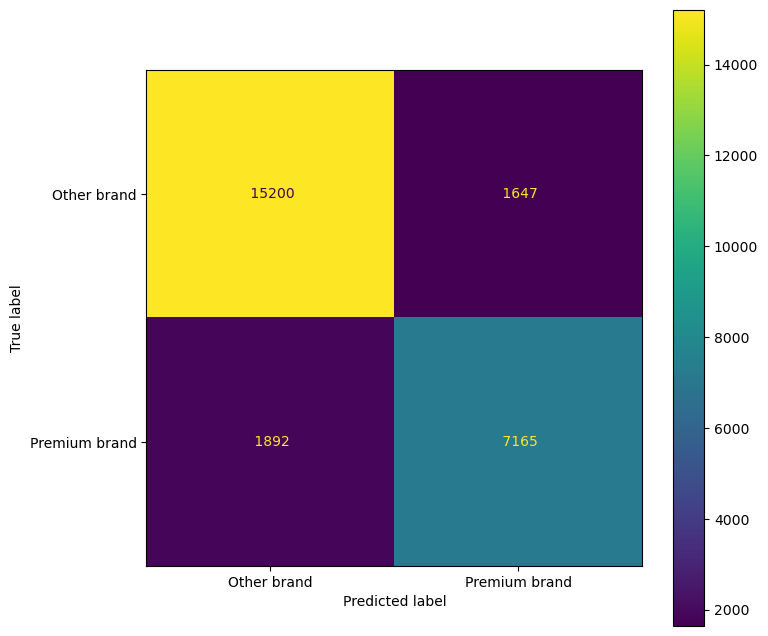

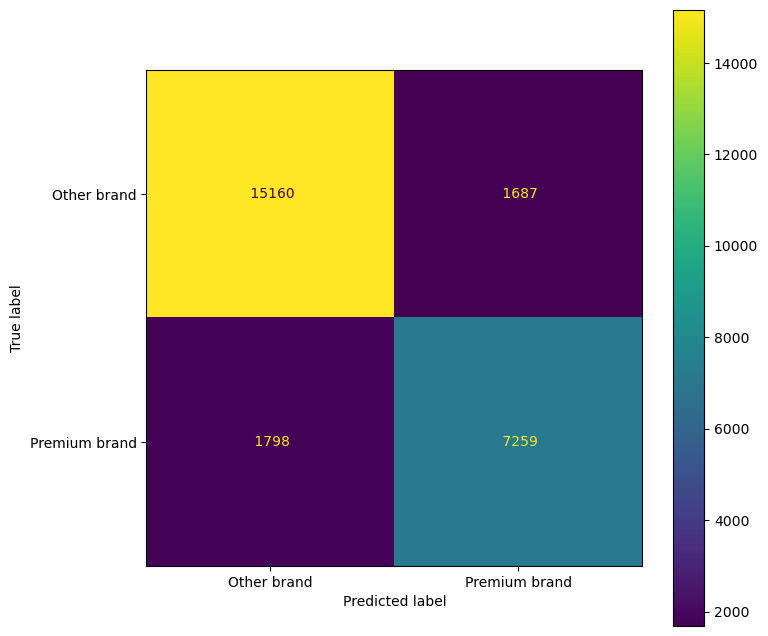

In [123]:
conf_matrix_show(mlp_clf, X_train_sc, y_train, brands)
conf_matrix_show(mlp_clf, X_val_sc, y_val, brands)
conf_matrix_show(mlp_clf, X_test_sc, y_test, brands)

The model started with solid accuracy (over 0.83), but improval wasn't significant.

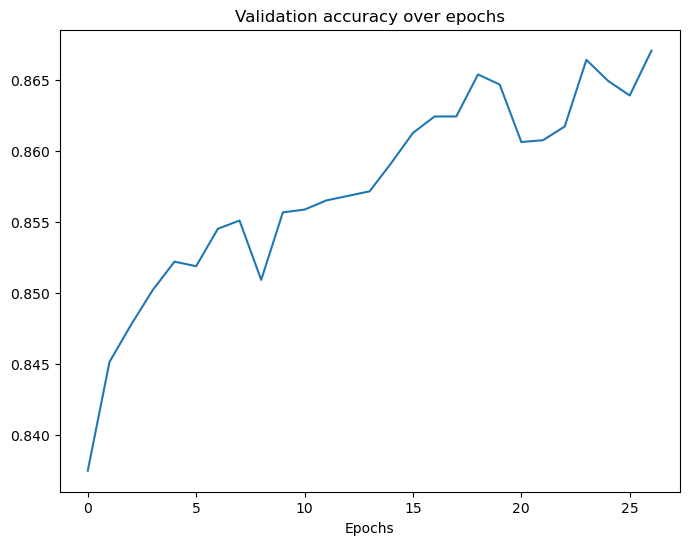

In [124]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(mlp_clf.validation_scores_)
plt.title("Validation accuracy over epochs", fontsize=12)
plt.xlabel('Epochs')
plt.show()

The next model will have less hidden layers, because model may be overfitted.

In [125]:
mlp_clf2 = MLPClassifier(
    hidden_layer_sizes=(40,20,5,2),
    early_stopping=True,
    verbose=True
)

start = time.time()
mlp_clf2.fit(X_train_sc, y_train)
mlp2_train_pred = mlp_clf2.predict(X_train_sc)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time: {mins}:{seconds} mins.")

Iteration 1, loss = 0.42524402
Validation score: 0.825130
Iteration 2, loss = 0.37580140
Validation score: 0.835617
Iteration 3, loss = 0.36615027
Validation score: 0.842373
Iteration 4, loss = 0.35942843
Validation score: 0.840636
Iteration 5, loss = 0.35526123
Validation score: 0.846748
Iteration 6, loss = 0.35137741
Validation score: 0.844046
Iteration 7, loss = 0.34891925
Validation score: 0.848485
Iteration 8, loss = 0.34667532
Validation score: 0.850093
Iteration 9, loss = 0.34453153
Validation score: 0.850415
Iteration 10, loss = 0.34285247
Validation score: 0.851702
Iteration 11, loss = 0.34178121
Validation score: 0.851702
Iteration 12, loss = 0.34078169
Validation score: 0.851766
Iteration 13, loss = 0.33979529
Validation score: 0.851509
Iteration 14, loss = 0.33897112
Validation score: 0.852216
Iteration 15, loss = 0.33822763
Validation score: 0.850351
Iteration 16, loss = 0.33700515
Validation score: 0.852731
Iteration 17, loss = 0.33671940
Validation score: 0.852988
Iterat

Network is two times faster, but scores are almost the same. Model still doesn't classify premium brands efficiently.

In [128]:
mlp2_val_pred = mlp_clf2.predict(X_val_sc)
mlp2_test_pred = mlp_clf2.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, mlp2_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, mlp2_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, mlp2_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.88      0.90      0.89    101082
           1       0.80      0.78      0.79     54341

    accuracy                           0.86    155423
   macro avg       0.84      0.84      0.84    155423
weighted avg       0.85      0.86      0.85    155423

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     16847
           1       0.79      0.77      0.78      9057

    accuracy                           0.85     25904
   macro avg       0.84      0.83      0.84     25904
weighted avg       0.85      0.85      0.85     25904

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     16847
           1       0.79      0.78      0.79      9057

    accuracy     

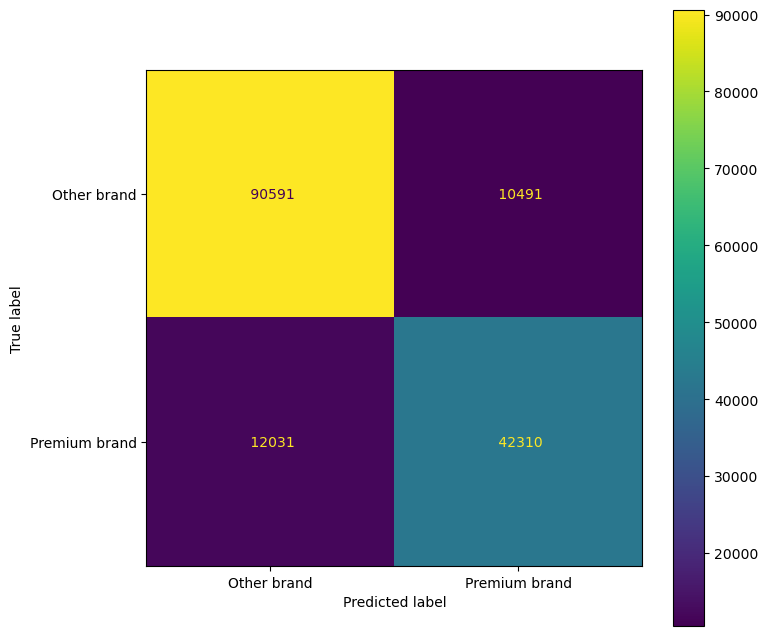

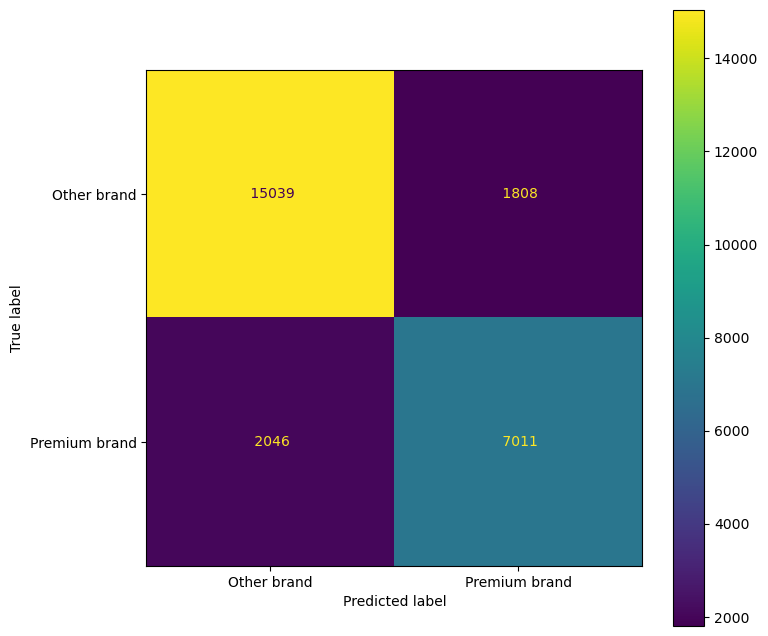

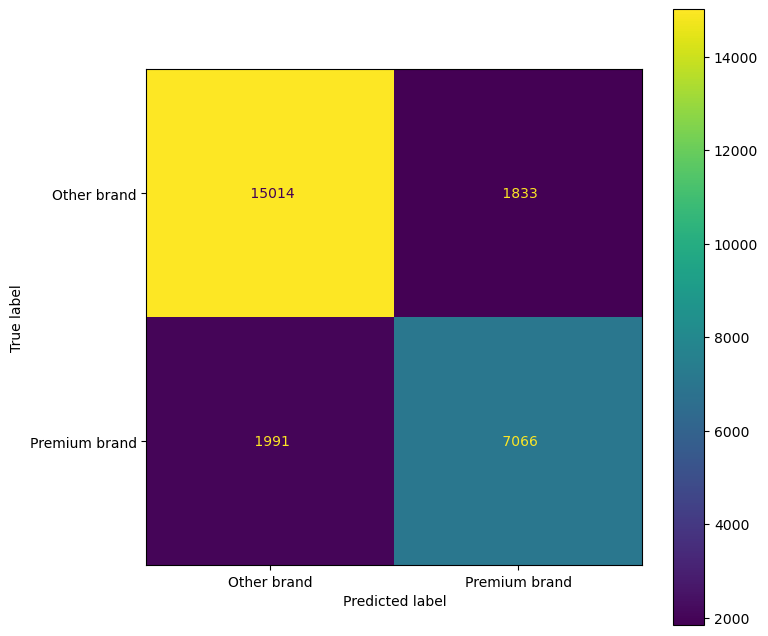

In [129]:
conf_matrix_show(mlp_clf2, X_train_sc, y_train, brands)
conf_matrix_show(mlp_clf2, X_val_sc, y_val, brands)
conf_matrix_show(mlp_clf2, X_test_sc, y_test, brands)

Also this instance didn't improve scores too much from the beginning of training.

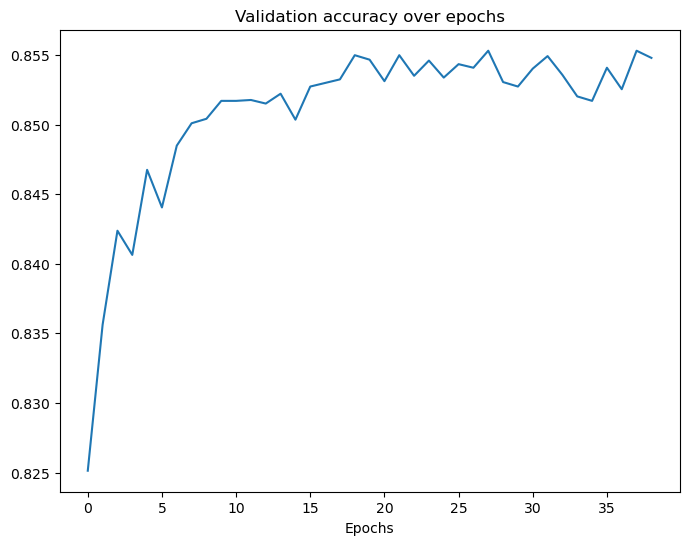

In [130]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(mlp_clf2.validation_scores_)
plt.title("Validation accuracy over epochs", fontsize=12)
plt.xlabel('Epochs')
plt.show()

# Summary.

From the four algorithms shown above XGBClassifier is the best option. The main task of the model is detection of true positives. Recalls of XGBClassifier and Balanced Random Forest Classifier are comparable, but XGBClassifier "wins" because of better precision - it makes much less false positive errors.

KNeighborsClassifier is fast, but has much more misclassifications and weak possibilities of tuning. ComplementNB's metrics disqualify this algorithm from being good solution of this classification problem. MLPClassifier fits to slowly and is unable to detect true positive samples.